In [1]:
# Basic Libraries

import numpy as np
import scipy as sp
import sympy as smp
from scipy.integrate import solve_ivp, odeint
import itertools
import mpmath
import opt_einsum as oe
import numba as nb
import symengine as sme


# For Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# For Debugging and Profiling
import snoop
from cProfile import Profile
from pstats import SortKey, Stats
import pyperclip

In [2]:
def get_norm(T, g):
    """
    T should have confuguration either 'u' or 'uu
    Returned Configuration: Scalar
    """
    if T.ndim == 2:
        return np.einsum("ua,vb,ab,uv->", g, g, T, T)

    else:
        # return np.einsum("ab,a,b->", g, T, T)
        return g.dot(T).dot(T)

In [3]:
# @nb.njit
def levi_civita_symbol(dim=4):
    """
    Define Levi Cevita Tensor
    Config: uuuu
    """

    arr = np.zeros(tuple([dim for _ in range(dim)]))
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = 1
        arr[x] = int(np.linalg.det(mat))
    return arr

In [4]:
# @snoop
# @nb.njit
def levi_civita_tensor(gk):
    #! uuuu
    epsu = levi_civita_symbol()
    det_g = np.linalg.det(gk)
    return epsu / np.sqrt(-(det_g))

In [5]:
@nb.njit
def cov_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: ll
    """
    #! Correction Added Mass term in the symbols
    g = np.zeros((4, 4), dtype=type(r))

    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    g[0, 0] = -(1.0 - 2.0 * M * r / Sigma)
    g[1, 1] = Sigma / Delta
    g[2, 2] = Sigma
    g[3, 3] = (
        np.sin(theta) ** 2
        * ((r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2)
        / Sigma
    )
    g[0, 3] = -2.0 * a * M * r * np.sin(theta) ** 2 / Sigma
    g[3, 0] = g[0, 3]

    # return g.astype(float)
    return g

In [6]:
@nb.njit
def cot_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: uu
    """
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    denom = Delta * np.sin(theta) ** 2

    g = np.zeros((4, 4), dtype=type(r))
    g[0, 0] = (
        -(
            np.sin(theta) ** 2
            * ((r**2 + a**2) ** 2 - Delta * a**2 * np.sin(theta) ** 2)
            / Sigma
        )
        / denom
    )

    g[1, 1] = Delta / Sigma

    g[2, 2] = 1.0 / Sigma

    # g[3, 3] = -(-(1.0 - 2.0 * r / Sigma)) / denom
    #! Corrected the g[3,3] term below
    g[3, 3] = (Delta - a**2 * np.sin(theta) ** 2) / (denom * Sigma)

    g[0, 3] = (-2.0 * a * M * r * np.sin(theta) ** 2 / Sigma) / denom

    g[3, 0] = g[0, 3]

    return g
    # return g

In [7]:
@nb.njit
def kerr_christoffel(r, theta, a, M=1.0):
    """
    Function to give the christoffel symbols for kerr metric.
    The christoffel symbols are given as \Gamma ^i _{jk}

    From Reference Paper, Appendix
    Config: ull
    """

    cs = np.zeros((4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    cs[3, 0, 1] = M * (2 * r**2 - Sigma) / (Delta * Sigma**2) * a
    cs[0, 0, 1] = (
        M * (r**2 + a**2) * (r**2 - a**2 * np.cos(theta) ** 2) / (Sigma**2 * Delta)
    )

    cs[3, 0, 2] = -2 * M * a * r * (np.cos(theta) /np.sin(theta)) / (Sigma**2)
    cs[0, 0, 2] = -2 * M * a**2 * r *np.sin(theta) * np.cos(theta) / Sigma**2

    cs[0, 1, 3] = (
        -M
        * a
        * (2 * r**2 * (r**2 + a**2) + Sigma * (r**2 - a**2))
        *np.sin(theta) ** 2
        / (Delta * Sigma**2)
    )

    cs[3, 1, 3] = (
        r * Sigma * (Sigma - 2 * M * r)
        - M * a**2 * (2 * r**2 - Sigma) *np.sin(theta) ** 2
    ) / (Delta * Sigma**2)

    cs[0, 2, 3] = M * a**3 * r *np.sin(theta) ** 2 *np.sin(2 * theta) / Sigma**2

    cs[3, 2, 3] = (
        (np.cos(theta) /np.sin(theta))
        * (Sigma**2 + 2 * M * a**2 * r *np.sin(theta) ** 2)
        / Sigma**2
    )

    cs[1, 0, 0] = M * Delta * (2 * r**2 - Sigma) / Sigma**3

    cs[1, 0, 3] = -cs[1, 0, 0] * a *np.sin(theta) ** 2

    cs[2, 0, 0] = -M * a * r *np.sin(2 * theta) / Sigma**3 * a
    cs[2, 0, 3] = (
        2.0 * M * r * a * (r**2 + a**2) *np.sin(theta) * np.cos(theta) / Sigma**3
    )

    cs[1, 1, 1] = r / Sigma + (M - r) / Delta

    cs[1, 2, 2] = -r * Delta / Sigma
    cs[2, 1, 2] = -cs[1, 2, 2] / Delta

    cs[1, 1, 2] = cs[2, 2, 2] = -(a**2) *np.sin(2 * theta) / (2 * Sigma)
    cs[2, 1, 1] = -cs[1, 1, 2] / Delta

    cs[1, 3, 3] = (
        -Delta
        * (r * Sigma**2 - M * a**2 * (2 * r**2 - Sigma) *np.sin(theta) ** 2)
        *np.sin(theta) ** 2
        / Sigma**3
    )

    cs[2, 3, 3] = (
        -(Delta * Sigma**2 + 2 * M * r * (r**2 + a**2) ** 2)
        *np.sin(2 * theta)
        / (2 * Sigma**3)
    )

    cs[0, 1, 0] = cs[0, 0, 1]
    cs[0, 2, 0] = cs[0, 0, 2]
    cs[0, 3, 1] = cs[0, 1, 3]
    cs[0, 3, 2] = cs[0, 2, 3]

    cs[1, 3, 0] = cs[1, 0, 3]
    cs[1, 2, 1] = cs[1, 1, 2]

    cs[2, 3, 0] = cs[2, 0, 3]
    cs[2, 2, 1] = cs[2, 1, 2]

    cs[3, 1, 0] = cs[3, 0, 1]
    cs[3, 2, 0] = cs[3, 0, 2]
    cs[3, 3, 1] = cs[3, 1, 3]
    cs[3, 3, 2] = cs[3, 2, 3]

    # return symmetrize(arr=cs)+np.zeros((4,4,4))
    return cs + np.zeros((4, 4, 4))
    # return cs

In [8]:
@nb.njit
def kerr_riemann_tensor(r, theta, a, M=1.0):
    """
    Define variables

    Components of the Riemann tensor for Kerr Metric
    From Reference Paper, Appendix
    The Configuration is ulll
    """

    rijkl = np.zeros((4, 4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2.0 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2

    rijkl[0, 0, 0, 3] = (
        2.0
        * M**2
        * np.sin(theta) ** 2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**4
    )

    rijkl[0, 0, 1, 2] = (
        -2.0
        * M**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * r
        * np.cos(theta)
        * a**2
        * np.sin(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 1] = (
        M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 0, 2] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 1, 3] = (
        3.0
        * M
        * np.sin(theta) ** 2
        * a
        * r
        * (r**2 + a**2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / (Sigma**3 * Delta)
    )

    rijkl[0, 1, 2, 3] = (
        -M
        * np.cos(theta)
        * np.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * np.sin(theta) ** 2 * Delta)
        / (Sigma**3 * Delta)
    )

    # Antisymmetric under exchange of last two indices.
    rijkl[0, 0, 3, 0] = -rijkl[0, 0, 0, 3]
    rijkl[0, 0, 2, 1] = -rijkl[0, 0, 1, 2]
    rijkl[0, 1, 1, 0] = -rijkl[0, 1, 0, 1]
    rijkl[0, 1, 2, 0] = -rijkl[0, 1, 0, 2]
    rijkl[0, 1, 3, 1] = -rijkl[0, 1, 1, 3]
    rijkl[0, 1, 3, 2] = -rijkl[0, 1, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[0, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2 * a**2 * np.sin(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 2, 1, 3] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * ((a**2 + r**2) ** 2 + 2.0 * a**2 * np.sin(theta) ** 2 * Delta)
        * a
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )
    rijkl[0, 2, 2, 3] = (
        -3.0
        * M
        * np.sin(theta) ** 2
        * r
        * a
        * (a**2 + r**2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[0, 3, 0, 3] = (
        -np.sin(theta) ** 2
        * M
        * r
        * (r**2 + 3 * a**2 * np.sin(theta) ** 2 - 3 * a**2)
        * ((a**2 + r**2) ** 2 - a**2 * np.sin(theta) ** 2 * Delta)
        / Sigma**4
    )
    rijkl[0, 3, 1, 2] = (
        (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * M
        * ((a**2 + r**2) ** 2 - a**2 * np.sin(theta) ** 2 * Delta)
        * a
        * np.sin(theta)
        * np.cos(theta)
        / (Sigma**3 * Delta)
    )

    # Symmetries
    rijkl[0, 2, 1, 0] = -rijkl[0, 2, 0, 1]
    rijkl[0, 2, 2, 0] = -rijkl[0, 2, 0, 2]
    rijkl[0, 2, 3, 1] = -rijkl[0, 2, 1, 3]
    rijkl[0, 2, 3, 2] = -rijkl[0, 2, 2, 3]
    rijkl[0, 3, 3, 0] = -rijkl[0, 3, 0, 3]
    rijkl[0, 3, 2, 1] = -rijkl[0, 3, 1, 2]

    #! ------------------------------------------------------------------------------#

    rijkl[1, 0, 0, 1] = (
        r
        * M
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 + 2.0 * Delta)
        / Sigma**4
    )
    rijkl[1, 0, 0, 2] = (
        -3.0
        * M
        * Delta
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / Sigma**4
    )
    rijkl[1, 0, 1, 3] = (
        r
        * M
        * a
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[1, 0, 2, 3] = (
        -a
        * M
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[1, 2, 0, 3] = (
        -np.cos(theta)
        * M
        * np.sin(theta)
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        / Sigma**3
    )
    rijkl[1, 2, 1, 2] = -M * r * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / Sigma**2
    rijkl[1, 3, 0, 1] = (
        -np.sin(theta) ** 2
        * M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        / Sigma**4
    )
    rijkl[1, 3, 0, 2] = (
        a
        * M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[1, 3, 1, 3] = (
        -np.sin(theta) ** 2
        * M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * ((r**2 + a**2) ** 2 + 2.0 * a**2 * Delta * np.sin(theta) ** 2)
        / Sigma**4
    )
    rijkl[1, 3, 2, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * Delta
        * np.cos(theta)
        * np.sin(theta) ** 3
        / Sigma**4
    )

    # Symmetries
    rijkl[1, 0, 1, 0] = -rijkl[1, 0, 0, 1]
    rijkl[1, 0, 2, 0] = -rijkl[1, 0, 0, 2]
    rijkl[1, 0, 3, 1] = -rijkl[1, 0, 1, 3]
    rijkl[1, 0, 3, 2] = -rijkl[1, 0, 2, 3]
    rijkl[1, 2, 3, 0] = -rijkl[1, 2, 0, 3]
    rijkl[1, 2, 2, 1] = -rijkl[1, 2, 1, 2]
    rijkl[1, 3, 1, 0] = -rijkl[1, 3, 0, 1]
    rijkl[1, 3, 2, 0] = -rijkl[1, 3, 0, 2]
    rijkl[1, 3, 3, 1] = -rijkl[1, 3, 1, 3]
    rijkl[1, 3, 3, 2] = -rijkl[1, 3, 2, 3]

    #! -------------------------------------------------------------------------------------#

    rijkl[2, 0, 0, 1] = (
        -3.0
        * M
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.sin(theta)
        * np.cos(theta)
        / Sigma**4
    )
    rijkl[2, 0, 0, 2] = (
        -M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (2.0 * a**2 * np.sin(theta) ** 2 + Delta)
        / Sigma**4
    )
    rijkl[2, 0, 1, 3] = (
        -a
        * M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[2, 0, 2, 3] = (
        -M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 1, 0, 3] = (
        M
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**3
    )
    rijkl[2, 1, 1, 2] = (
        M * r * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / (Delta * Sigma**2)
    )
    rijkl[2, 3, 0, 1] = (
        M
        * a
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / Sigma**4
    )
    rijkl[2, 3, 0, 2] = (
        M
        * r
        * a
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[2, 3, 1, 3] = (
        3.0
        * M
        * a**2
        * (r**2 + a**2)
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta) ** 3
        / Sigma**4
    )
    rijkl[2, 3, 2, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (2.0 * (r**2 + a**2) ** 2 + a**2 * Delta * np.sin(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )

    # Symmetries
    rijkl[2, 0, 1, 0] = -rijkl[2, 0, 0, 1]
    rijkl[2, 0, 2, 0] = -rijkl[2, 0, 0, 2]
    rijkl[2, 0, 3, 1] = -rijkl[2, 0, 1, 3]
    rijkl[2, 0, 3, 2] = -rijkl[2, 0, 2, 3]
    rijkl[2, 1, 3, 0] = -rijkl[2, 1, 0, 3]
    rijkl[2, 1, 2, 1] = -rijkl[2, 1, 1, 2]
    rijkl[2, 3, 1, 0] = -rijkl[2, 3, 0, 1]
    rijkl[2, 3, 2, 0] = -rijkl[2, 3, 0, 2]
    # rijkl[2, 3, 2, 1] = -rijkl[2, 3, 1, 2]
    rijkl[2, 3, 3, 1] = -rijkl[2, 3, 1, 3]
    rijkl[2, 3, 3, 2] = -rijkl[2, 3, 2, 3]

    #! --------------------------------------------------------------------------#

    rijkl[3, 0, 1, 2] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 - Delta)
        * a
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 1] = (
        3.0 * M * r * a * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / (Delta * Sigma**3)
    )
    rijkl[3, 1, 0, 2] = (
        -M
        * a
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (2.0 * a**2 * np.sin(theta) ** 2 + Delta)
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 1, 3] = (
        M
        * r
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * (r**2 + a**2 + 2.0 * a**2 * np.sin(theta) ** 2)
        / (Delta * Sigma**3)
    )
    rijkl[3, 1, 2, 3] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 2.0 * M * r)
        * a**2
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 1] = (
        -M
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * (a**2 * np.sin(theta) ** 2 + 2.0 * Delta)
        * a
        * (np.cos(theta) / np.sin(theta))
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 0, 2] = (
        -M * 3.0 * r * a * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2) / Sigma**3
    )
    rijkl[3, 2, 1, 3] = (
        -M
        * a**2
        * (3 * r**2 - a**2 * np.cos(theta) ** 2)
        * (3.0 * (r**2 + a**2) - 4.0 * M * r)
        * np.sin(theta)
        * np.cos(theta)
        / (Delta * Sigma**3)
    )
    rijkl[3, 2, 2, 3] = (
        -M
        * r
        * (2.0 * (r**2 + a**2) + a**2 * np.sin(theta) ** 2)
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        / Sigma**3
    )
    rijkl[3, 3, 0, 3] = (
        -2.0
        * M**2
        * a
        * r**2
        * (r**2 - 3.0 * a**2 * np.cos(theta) ** 2)
        * np.sin(theta) ** 2
        / Sigma**4
    )
    rijkl[3, 3, 1, 2] = (
        2.0
        * M**2
        * r
        * a**2
        * (3.0 * r**2 - a**2 * np.cos(theta) ** 2)
        * np.cos(theta)
        * np.sin(theta)
        / (Delta * Sigma**3)
    )

    # Symmetries
    rijkl[3, 0, 2, 1] = -rijkl[3, 0, 1, 2]
    rijkl[3, 1, 1, 0] = -rijkl[3, 1, 0, 1]
    rijkl[3, 1, 2, 0] = -rijkl[3, 1, 0, 2]
    rijkl[3, 1, 3, 1] = -rijkl[3, 1, 1, 3]
    rijkl[3, 1, 3, 2] = -rijkl[3, 1, 2, 3]
    rijkl[3, 2, 1, 0] = -rijkl[3, 2, 0, 1]
    rijkl[3, 2, 2, 0] = -rijkl[3, 2, 0, 2]
    rijkl[3, 2, 3, 1] = -rijkl[3, 2, 1, 3]
    rijkl[3, 2, 3, 2] = -rijkl[3, 2, 2, 3]
    rijkl[3, 3, 3, 0] = -rijkl[3, 3, 0, 3]
    rijkl[3, 3, 2, 1] = -rijkl[3, 3, 1, 2]

    #!---------------------------------------------------------------------#

    part1 = a**2 + 2 * r * (-2 * M + r) + a**2 * np.cos(2 * theta)
    part2 = 3 * a**2 - 2 * r**2 + 3 * a**2 * np.cos(2 * theta)
    part3 = (a**2 + 2 * r**2 + a**2 * np.cos(2 * theta)) ** 4
    # Calculating Rtensor elements

    # rijkl[3, 0, 0, 3] =  (part1 + part2 + part3 + part4) / (Sigma**5)
    rijkl[3, 0, 0, 3] = 4 * M * r * part1 * part2 / part3
    rijkl[3, 0, 3, 0] = -rijkl[3, 0, 0, 3]

    return rijkl + np.zeros((4, 4, 4, 4))



In [9]:
def spintensor(levi, pvector, svector, m):

    #! Using above definition
    return -np.einsum("uvab,a,b->uv", levi, svector, pvector) / m

In [10]:
@nb.njit
def metric_D(r, theta, a, M=1.0):
    dgkt = np.zeros((4, 4), dtype=type(r))
    dgkp = np.zeros((4, 4), dtype=type(r))

    denom = (r**2 + a**2 * np.cos(theta) ** 2) ** 2

    dgkt[1, 0] = M * (a**2 - 2 * r**2 + a**2 * np.cos(2 * theta)) / denom
    dgkt[1, 3] = (
        -(2 * a * M * (-(r**2) + a**2 * np.cos(theta) ** 2) * np.sin(theta) ** 2)
        / denom
    )
    dgkt[2, 0] = 2 * a**2 * M * r * np.sin(2 * theta) / denom
    dgkt[2, 3] = -2 * a * M * r * (r**2 + a**2) * np.sin(2 * theta) / denom

    dgkp[1, 0] = (
        -2 * a * M * (-(r**2) + a**2 * np.cos(theta) ** 2) * np.sin(theta) ** 2 / denom
    )

    dgkp[1, 3] = (
        2
        * np.sin(theta) ** 2
        * (
            np.cos(theta) ** 2
            * (2 * a**2 * r * (a**2 + r**2) + a**4 * (M - r) * np.sin(theta) ** 2)
            + r * (-(a**4) + r**4 + a**2 * (a**2 - M * r) * np.sin(theta) ** 2)
        )
        / denom
    )

    dgkp[2, 0] = -2 * a * M * r * (a**2 + r**2) * np.sin(2 * theta) / denom
    dgkp[2, 3] = (
        (
            3 * a**6
            + 10 * a**4 * M * r
            + 11 * a**4 * r**2
            + 16 * a**2 * M * r**3
            + 16 * a**2 * r**4
            + 8 * r**6
            + 4
            * a**2
            * (a**2 + 2 * r**2)
            * (a**2 + r * (-2 * M + r))
            * np.cos(2 * theta)
            + a**4 * (a**2 - 2 * M * r + r**2) * np.cos(4 * theta)
        )
        * np.sin(2 * theta)
        / (8 * denom)
    )

    return dgkt.T + np.zeros((4, 4)), dgkp.T + np.zeros((4, 4))

In [11]:
# @snoop
def energy(pvector, Stensor, dgkt):

    term2 = np.einsum("uv,uv->", dgkt, Stensor) / 2.0
    return -pvector[0] + term2

In [12]:
def angular_momentum(pvector, Stensor, dgkp):

    term2 = np.einsum("uv,uv->", dgkp, Stensor) / 2.0
    return pvector[3] - term2

In [13]:
# def spin_matrix(sa, pb, epsilon, m):
#     """
#     Resultant Config: aa
#     Input Config: u,u,uu,uuuu
#     In Tetrad Basis or Coordinate basis
#     Output Config: uu
#     Gives same output as above
#     """
#     return -np.einsum("bdkl,k,l->bd", epsilon ,sa ,pb) / m

In [14]:
def to_cartesian(rsol):
    r, t, p = rsol[:, 1], rsol[:, 2], rsol[:, 3]

    x = r * np.sin(t) * np.cos(p)
    y = r * np.sin(t) * np.sin(p)
    z = r * np.cos(t)

    return np.concatenate((x[:, None], y[:, None], z[:, None]), axis=1)

In [15]:
# @snoop
def calculate_four_velocity(gk,gkinv,pvector,svector, ddRuuuu):



    # correction= -np.einsum("uabg,a,b,g->u",ddRuuuu,svector,pvector,svector)
    correction = -ddRuuuu.dot(svector).dot(pvector).dot(svector)

    # pvecu= np.einsum("ij,j->i",gkinv,pvector)
    pvecu= gkinv.dot(pvector)

    N = np.sqrt(1.0 / (1.0 - gk.dot(correction).dot(correction) + 2.0*pvector.dot(correction)))



    dx= N*(pvecu+ correction)

    return dx

In [16]:
def calculate_four_spin(pvector, uvector, svector, cs,dRuluu):

    # correction= -np.einsum("u,abgd,a,b,g,d->u",pvector,dRuluu,svector,uvector,pvector,svector)
    correction = -pvector * dRuluu.dot(svector).dot(pvector).dot(uvector).dot(svector)

    # ds = correction + np.einsum("auv,a,u->v", cs, svector, uvector)
    ds = correction + cs.transpose(2, 0, 1).dot(uvector).dot(svector)

    return ds

In [17]:
def calculate_four_momentum(pvector, uvector, svector, cs, dRlluu):

    # correction= -np.einsum("uvab,v,a,b->u",dRlluu,uvector,pvector,svector)
    correction = -dRlluu.dot(svector).dot(pvector).dot(uvector)
    # dp = correction + np.einsum("auv,a,u->v", cs, pvector, uvector)
    dp = correction + cs.transpose(2, 0, 1).dot(uvector).dot(pvector)

    return dp

In [18]:
def MPD(t, y, p):
    t, r, theta, phi, pt, pr, ptheta, pphi, st, sr, stheta, sphi = y

    a, m, M = p

    # xvector=y[:4]
    pvector = y[4:8]  #! p_u
    svector = y[8:]  #! s_u

    gk = cov_metric_tensor(r, theta, a, M)  #! g_{ij}
    gkinv = cot_metric_tensor(r, theta, a, M)
    cs = kerr_christoffel(r, theta, a, M)  #! G^i_{jk}

    Riemann = kerr_riemann_tensor(r, theta, a, M)  #! R^a_{bcd}

    # Riemann_cov = np.einsum("ul,lvps->uvps", gk, Riemann)  #! R_{abcd}
    # Riemann_uull = np.einsum("ap,upgd->uagd", gkinv, Riemann)  #! R^{ua}_{gd}

    levi = levi_civita_tensor(gk)  #! e^{abcd}
    # levi_mixed = np.einsum("psxy,xu,yv->psuv", levi, gk, gk)  #! e^{ps}_{uv}
    # levi_mixed= np.einsum("px,sy,xyuv->psuv",gk,gk,levi)
    levi_mixed = (
        gk.dot(
            gk.dot(levi.reshape((4, -1)))
            .reshape((4, 4, 4, 4))
            .transpose(1, 0, 2, 3)
            .reshape((4, -1))
        )
        .reshape((4, 4, 4, 4))
        .transpose(1, 0, 2, 3)
    )

    # dRuluu= 0.5*np.einsum("abps,psuv->abuv",Riemann,levi)
    dRuluu = 0.5 * np.matmul(Riemann.reshape((-1, 16)), levi.reshape((16, -1))).reshape(
        (4, 4, 4, 4)
    )
    # dRlluu= np.einsum("ia,abuv->ibuv",gk,dRuluu)
    dRlluu = gk.dot(dRuluu.reshape((4, -1))).reshape((4, 4, 4, 4))

    ddRuuuu= 0.5*np.einsum("bi,aips,psuv->abuv",gkinv,dRuluu,levi_mixed)

    # stensor = spintensor(levi, pvector=pvector, svector=svector, gk=gk, m=m)  #! S^{uv}

    uvector = calculate_four_velocity(gk=gk,gkinv=gkinv,
        pvector=pvector, svector=svector,ddRuuuu=ddRuuuu)  #!dx_mu

    dp = calculate_four_momentum(
        pvector=pvector,
        uvector=uvector,
        svector=svector,
        cs=cs,
        dRlluu=dRlluu
    )
    #!dp_{mu}

    ds = calculate_four_spin(
        pvector=pvector,
        uvector=uvector,
        svector=svector,
        cs=cs,
        dRuluu=dRuluu
    )
    #!ds^{mu}

    dy = np.zeros_like(y)

    dy[0:4] = uvector
    dy[4:8] = dp
    dy[8:] = ds

    return dy

In [19]:
# @snoop
def get_constants(rsol, gk,gkinv, a,m, M=1.0):
    _, r, theta, _ = rsol[:4]
    pmul = rsol[4:8]
    smul = rsol[8:]

    dgkt, dgkp = metric_D(r, theta=theta, a=a, M=M)

    levi = levi_civita_tensor(gk=gk)  #!'uuuu'
    # Sab=spin_matrix(sa=si,pb=pi,gk=eta,epsilon=epsilon)
    Suv = spintensor(levi, pmul, smul, m)

    E = energy(pmul, Suv, dgkt)
    Jz = angular_momentum(pmul, Suv, dgkp)

    mu = get_norm(T=pmul, g=gkinv)
    Smag = get_norm(T=smul, g=gkinv)

    # ps = np.einsum("ij,j,i->", gkinv, pmul, smul)
    ps= gkinv.dot(pmul).dot(smul)

    return E, Jz, mu, Smag, ps

In [20]:
M = 1e0
m = 1e0

S = 1e0*m*M 
E = 0.8837 * m
Jz = 2.8 * m * M

r0 = 6.0 * M
theta0 = np.pi / 2.0
phi0 = 0.0
a0 = 1.0 * M

P1 = 1e-2 * m
S1 = 1e-4 * m
S2 = 1e-4 * m

In [21]:
v_ = np.sqrt(M / r0)
abar = a0 / M

Epro = (1 - 2 * v_**2 + abar * v_**3) / (np.sqrt(1 - 3 * v_**2 + 2 * abar * v_**3))
Eret = (1 - 2 * v_**2 - abar * v_**3) / (np.sqrt(1 - 3 * v_**2 - 2 * abar * v_**3))

ideg = np.pi / 30
ecc = 0.01
alpha_ip = 1 + np.cos(ideg)
alpha_im = 1 - np.cos(ideg)

E = 0.5 * (alpha_ip * Epro + alpha_im * Eret)
Jz = np.cos(ideg) * np.sqrt((1 - ecc**2) / (2 * (1 - E)))

In [22]:
E,Jz

(0.921403390470039, 2.50827834849913)

In [23]:
gk = cov_metric_tensor(r=r0, theta=theta0, a=a0, M=M)
gkinv = cot_metric_tensor(r=r0, theta=theta0, a=a0, M=M)

In [24]:
cs = kerr_christoffel(r=r0, theta=theta0, a=a0, M=M)

In [25]:
# rllll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M, config="llll")
rulll = kerr_riemann_tensor(r=r0, theta=theta0, a=a0, M=M)
# ruull=np.einsum("ij,ujps->uips",gkinv,rulll)

In [26]:
levi = levi_civita_tensor(gk)
#!epsilon^{uuuu}

In [27]:
levi_mixed = np.einsum("px,sy,xyuv->psuv", gk, gk, levi)

In [28]:
dgkt, dgkp = metric_D(r0, theta0, a0, M)

In [29]:
p0, p2, p3 = sme.symbols("p0 p2 p3", real=True)
#!Coordinate Components, 'l'

In [30]:
s0, s3 = sme.symbols("s0 s3", real=True)
#!Coordinate Components, 'l'

In [31]:
gpcoordu = np.array([p0, P1, p2, p3])
gscoordu = np.array([s0, S1, S2, s3])

#!Config='l'

In [32]:
# Definitions
Delta = a0**2 - 2 * M * r0 + r0**2
Sigma = r0**2 + a0**2 * sme.cos(theta0) ** 2

In [33]:
# Sab = spi(sa=gsi, pb=gpi, gk=eta, epsilon=epsl)
Suv = spintensor(levi=levi, pvector=gpcoordu, svector=gscoordu, m=m)
#!Config: uu, In Coordinate Basis

In [34]:
smp.Matrix(Suv).expand()

Matrix([
[                                                 0,    0.0277777777777778*p2*s3 - 2.77777777777778e-6*p3,    2.77777777777778e-6*p3 - 0.000277777777777778*s3,       2.77777777777778e-8 - 2.77777777777778e-6*p2],
[-0.0277777777777778*p2*s3 + 2.77777777777778e-6*p3,                                                    0, 0.0277777777777778*p0*s3 - 0.0277777777777778*p3*s0, -2.77777777777778e-6*p0 + 0.0277777777777778*p2*s0],
[ -2.77777777777778e-6*p3 + 0.000277777777777778*s3, -0.0277777777777778*p0*s3 + 0.0277777777777778*p3*s0,                                                   0,   2.77777777777778e-6*p0 - 0.000277777777777778*s0],
[      2.77777777777778e-6*p2 - 2.77777777777778e-8,    2.77777777777778e-6*p0 - 0.0277777777777778*p2*s0,   -2.77777777777778e-6*p0 + 0.000277777777777778*s0,                                                  0]])

In [35]:
eq210a = energy(gpcoordu, Suv, dgkt) - E

In [36]:
eq210a.expand()

-0.921403390470039 - 0.999999922839506*p0 + 7.71604938271605e-08*p3 - 5.82715169347377e-21*s0 - 1.57490586310102e-22*s3 - 0.000771604938271605*p2*s0 - 0.000771604938271605*p2*s3

In [37]:
eq210b = angular_momentum( gpcoordu, Suv, dgkp) - Jz

In [38]:
eq210b.expand()

-2.50827834849913 - 1.65895061728395e-05*p0 + 1.00000007716049*p3 - 6.40829195695805e-19*s0 - 5.82715169347377e-21*s3 + 0.165895061728395*p2*s0 - 0.000771604938271605*p2*s3

In [39]:
gpcoordu

array([p0, 0.01, p2, p3], dtype=object)

In [40]:
eq533 = get_norm(T=gpcoordu, g=gkinv) + 1.0

In [41]:
eq229 = np.einsum("ij,j,i->", gkinv, gpcoordu, gscoordu) - 0.0

In [42]:
eq228 = np.einsum("ij,j,i->", gkinv, gscoordu, gscoordu) - S**2

In [43]:
sme.sympify(eq533)

1.00006944444444 + p0*(-1.49333333333333*p0 - 0.0133333333333333*p3) + p3*(-0.0133333333333333*p0 + 0.0266666666666667*p3) + 0.0277777777777778*p2**2

In [44]:
eq210a.expand()

-0.921403390470039 - 0.999999922839506*p0 + 7.71604938271605e-08*p3 - 5.82715169347377e-21*s0 - 1.57490586310102e-22*s3 - 0.000771604938271605*p2*s0 - 0.000771604938271605*p2*s3

In [45]:
eq228.expand()

-0.999999992777778 - 0.0266666666666667*s0*s3 - 1.49333333333333*s0**2 + 0.0266666666666667*s3**2

In [46]:
eq229.expand()

6.94444444444444e-07 + 2.77777777777778e-06*p2 - 1.49333333333333*p0*s0 - 0.0133333333333333*p0*s3 - 0.0133333333333333*p3*s0 + 0.0266666666666667*p3*s3

In [47]:
eq210b.expand()

-2.50827834849913 - 1.65895061728395e-05*p0 + 1.00000007716049*p3 - 6.40829195695805e-19*s0 - 5.82715169347377e-21*s3 + 0.165895061728395*p2*s0 - 0.000771604938271605*p2*s3

In [48]:
# @snoop(depth=1,watch='x')
def solve_eq(p_0, p_2, p_3, s_0, s_3):
    f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])
    return f(p_0, p_2, p_3, s_0, s_3)


# f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])

In [49]:
# @snoop(depth=1,watch='x')
def solve_eq_sp(p):
    f = sme.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])
    return np.array(f(p[0], p[1], p[2], p[3], p[4]))


# f = smp.lambdify([p0, p2, p3, s0, s3], [eq210a, eq210b, eq533, eq228, eq229])

In [50]:
def jac_nl_symb():
    X = smp.Matrix([eq210a, eq210b, eq533, eq228, eq229])
    Y = smp.Matrix([p0, p2, p3, s0, s3])

    return X.jacobian(Y)

In [51]:
jac = jac_nl_symb()

In [52]:
def jac_nl(p_0, p_2, p_3, s_0, s_3):
    f = smp.lambdify([p0, p2, p3, s0, s3], jac)

    return f(p_0, p_2, p_3, s_0, s_3)

In [53]:
def jac_nl_sp(p):
    f = sme.lambdify([p0, p2, p3, s0, s3], jac)

    return f(p[0], p[1], p[2], p[3], p[4])

In [54]:
solve_eq(1.35794, 0.0302246, 0.088138, 0.571303, 0.185947)

[-2.279360939058426,
 -2.4173026286452175,
 -1.7565978798283257,
 -1.4893155764960702,
 -1.1621211190844907]

In [55]:
roots = mpmath.findroot(
    solve_eq,
    (-0.92,-1.33,2.55,0.0000038,-0.00065),
    solver="mdnewton",
    tol=1e-24,
    J=jac_nl,
    verify=True,
)

In [56]:
roots = np.array(roots.tolist(), dtype=np.float64)[:, 0]

In [57]:
solve_eq(*roots)

[0.0,
 0.0,
 -2.220446049250313e-16,
 -1.1102230246251565e-16,
 5.0961207875962946e-17]

In [58]:
solve_eq( -0.9336937594504036,
  1.3845005742603456,
  2.6926633362416004,
 -0.561736559309018,
  9.258742451177524)

[0.0029996021943459183,
 0.04548901769470515,
 0.011839124587664118,
 0.9534560080138764,
 0.017016262067360007]

In [59]:
roots.tolist()

[-0.927166844493032,
 -1.2011660536272417,
 2.594052411830842,
 0.39974187672615813,
 -6.618368418659201]

In [60]:
np0, np2, np3, ns0, ns3 = roots

In [61]:
ngpcoordu = np.array([np0, P1, np2, np3]).astype(np.float64)
ngscoordu = np.array([ns0, S1, S2, ns3]).astype(np.float64)

In [62]:
ngpcoordu, ngscoordu

(array([-0.92716684,  0.01      , -1.20116605,  2.59405241]),
 array([ 3.99741877e-01,  1.00000000e-04,  1.00000000e-04, -6.61836842e+00]))

In [63]:
Suv = spintensor(levi, ngpcoordu, ngscoordu, m)

In [64]:
Suv

array([[-0.00000000e+00,  2.20819446e-01,  1.84564137e-03,
         3.36435015e-06],
       [-2.20819446e-01, -0.00000000e+00,  1.41649455e-01,
        -1.33351016e-02],
       [-1.84564137e-03, -1.41649455e-01, -0.00000000e+00,
        -1.13614874e-04],
       [-3.36435015e-06,  1.33351016e-02,  1.13614874e-04,
        -0.00000000e+00]])

In [65]:
get_norm(ngpcoordu, gkinv)

-0.9999999999999984

In [66]:
get_norm(ngscoordu, gkinv)

0.9999999999999982

In [67]:
dRuluu= 0.5*np.einsum("abps,psuv->abuv",rulll,levi)
ddRuuuu= 0.5*np.einsum("bi,aips,psuv->abuv",gkinv,dRuluu,levi_mixed)

In [68]:
dRlluu = np.einsum("ia,abuv->ibuv", gk, dRuluu)

In [69]:
vmu0= calculate_four_velocity(gk=gk,gkinv=gkinv,pvector=ngpcoordu,svector=ngscoordu,ddRuuuu=ddRuuuu)

In [70]:
vmu0

array([ 1.33675022,  0.00686898, -0.0335339 ,  0.08073778])

In [71]:
calculate_four_momentum(ngpcoordu,vmu0,ngscoordu,cs,dRlluu)

array([ 1.90690026e-05, -1.68170501e-03,  7.64234369e-05,  1.66432523e-05])

In [72]:
calculate_four_spin(ngpcoordu,vmu0,ngscoordu,cs,dRuluu)

array([ 7.73583897e-05, -7.66743332e-02,  3.03645849e-05, -7.62708820e-03])

In [73]:
#!The initial conditions
#!We pass r0^mu,p^mu and S^mu
y0 = np.array(
    [
        0.0,
        r0,
        theta0,
        phi0,
        ngpcoordu[0],
        ngpcoordu[1],
        ngpcoordu[2],
        ngpcoordu[3],
        ngscoordu[0],
        ngscoordu[1],
        ngscoordu[2],
        ngscoordu[3],
    ]
).astype(np.float64)

In [74]:
y0.tolist()

[0.0,
 6.0,
 1.5707963267948966,
 0.0,
 -0.927166844493032,
 0.01,
 -1.2011660536272417,
 2.594052411830842,
 0.39974187672615813,
 0.0001,
 0.0001,
 -6.618368418659201]

In [75]:
p = [a0, m, M]

In [76]:
p

[1.0, 1.0, 1.0]

In [77]:
MPD(0.0, y0, p).tolist()

[1.3367502217537344,
 0.006868983893934941,
 -0.033533898668334214,
 0.08073778038103233,
 1.9069002636313338e-05,
 -0.0016817050070098358,
 7.642343694853167e-05,
 1.664325234070548e-05,
 7.73583897451938e-05,
 -0.07667433316010173,
 3.036458488758114e-05,
 -0.007627088202534062]

In [78]:
%%timeit
MPD(0.0, y0, p).tolist()

324 µs ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
get_constants(y0, gk,gkinv, a0, m, M)

(0.9214033904700393,
 2.5082783484991396,
 -0.9999999999999984,
 0.9999999999999982,
 1.5543122344752192e-15)

In [80]:
@nb.njit
def poincare(t, y, *args):
    # return y[3]%np.pi -1.
    if (y[2] - (np.pi / 2)) > 0:
        return 1
        # return y[1]
        # return rhs27(y[:4],y[4:8]/m,y[8:],metric_tensor(y[1],y[2],a0,M),epsl,a0,m,"u",M)[2]-np.pi/2
    else:
        return -1  # Impossible Conditions

In [81]:
# poincare.direction =0

In [82]:
sol = solve_ivp(
    fun=MPD,
    t_span=[0.0, 50000.0],
    y0=y0,
    method="LSODA",
    t_eval=np.arange(0.0, 50000.0 + 1, 1),
    events=poincare,
    args=(p,),
    rtol=1e-12,
    atol=1e-12,
)

In [83]:
rsol = sol.y.T

In [84]:
i = -1
gki = cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M)
gkinvi = cot_metric_tensor(rsol[i][1], rsol[i][2], a0, M)
(
    get_constants(rsol=rsol[i], gk=gki,gkinv=gkinvi, a=a0, m=m, M=M)[0] - E,
    get_constants(rsol=rsol[i], gk=gki,gkinv=gkinvi, a=a0, m=m, M=M)[1] - Jz,
    get_constants(rsol=rsol[i], gk=gki,gkinv=gkinvi, a=a0, m=m, M=M)[2] + m**2,
    get_constants(rsol=rsol[i], gk=gki,gkinv=gkinvi, a=a0, m=m, M=M)[3] - S**2,
)

(5.9935389984389076e-12,
 -2.4656543473611237e-10,
 -1.3792944564272602e-10,
 -1.4313750185124263e-10)

In [85]:
motconst = np.array(
    [
        get_constants(
            rsol[i],
            cov_metric_tensor(rsol[i][1], rsol[i][2], a0, M),
            cot_metric_tensor(rsol[i][1], rsol[i][2], a0, M),
            a0,
            m,
            M,
        )
        - np.array([E, Jz, -(1.0), S**2, 0.0])
        for i in range(len(rsol))
    ]
)

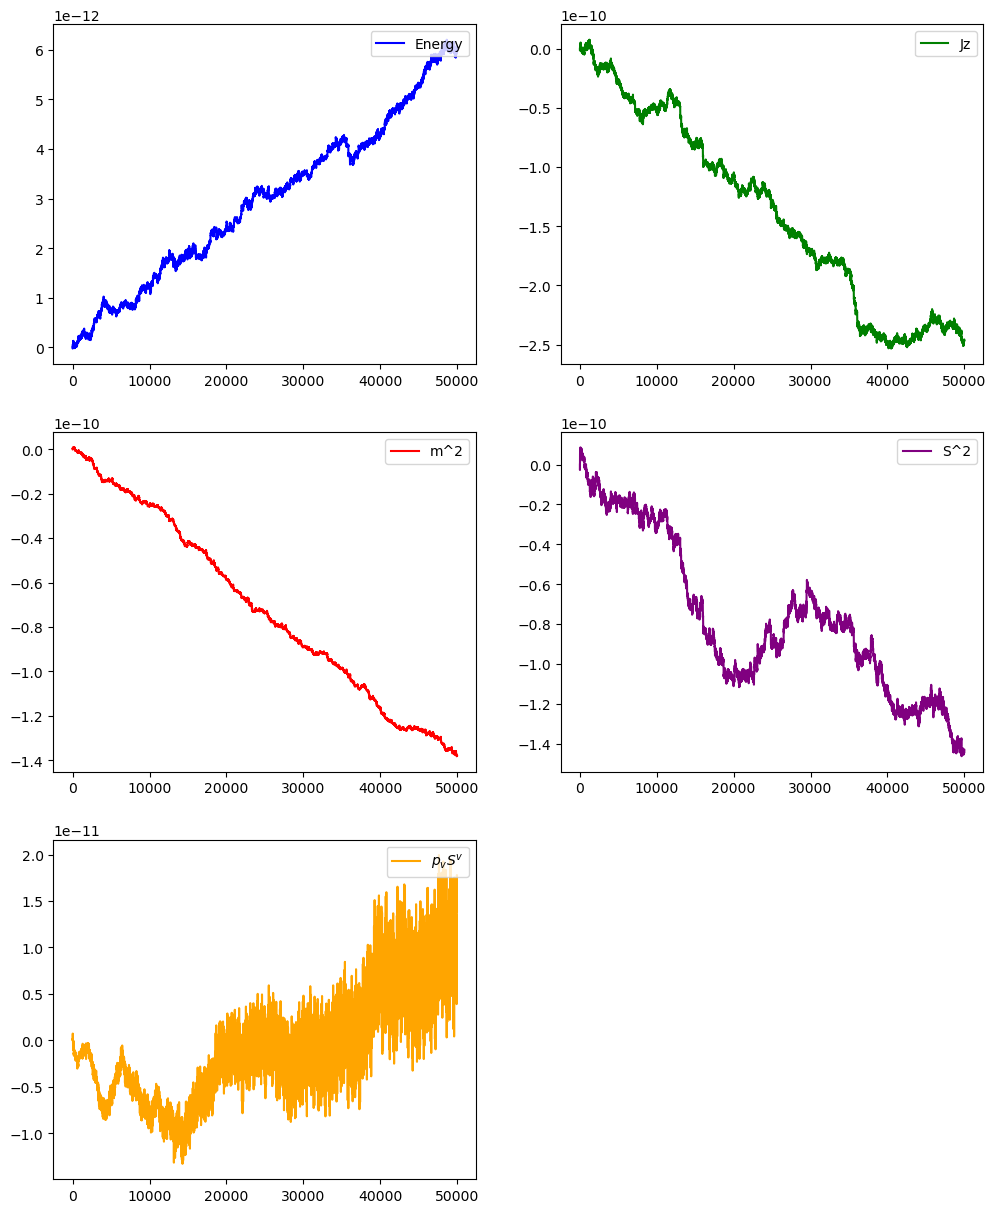

In [86]:
f, ax = plt.subplots(3, 2, figsize=(12, 15))
ax[0, 0].plot(sol.t, motconst[:, 0], label="Energy", color="blue")
ax[0, 1].plot(sol.t, motconst[:, 1], label="Jz", color="green")
ax[1, 0].plot(sol.t, motconst[:, 2], label="m^2", color="red")
ax[1, 1].plot(sol.t, motconst[:, 3], label="S^2", color="purple")
ax[2, 0].plot(sol.t, motconst[:, 4], label=r"$p_v S^v$", color="orange")
ax[0, 0].legend(loc="upper right")
ax[0, 1].legend(loc="upper right")
ax[1, 0].legend(loc="upper right")
ax[1, 1].legend(loc="upper right")
ax[2, 0].legend(loc="upper right")
f.delaxes(ax[2, 1])

In [87]:
pmag= np.zeros(len(rsol))
for i in range(len(rsol)):
    gkinv_=cot_metric_tensor(rsol[i][1],rsol[i][2],a0,M)
    pmag[i]= get_norm(rsol[i][4:8],gkinv_)

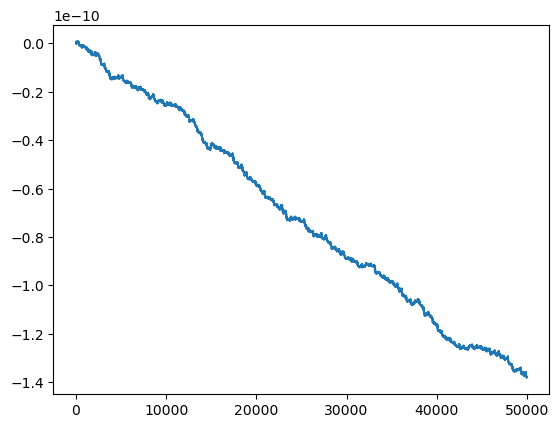

In [88]:
plt.plot(pmag-(-m**2))

In [89]:
crsol = to_cartesian(rsol=rsol)

In [90]:
crsol

array([[ 6.00000000e+00,  0.00000000e+00,  3.67394040e-16],
       [ 5.98351647e+00,  4.83720125e-01,  2.01019329e-01],
       [ 5.92061497e+00,  9.63329612e-01,  4.00970364e-01],
       ...,
       [-3.75531775e+00,  3.39212035e+00,  2.76926449e+00],
       [-4.04534007e+00,  2.95840596e+00,  2.88606922e+00],
       [-4.29560861e+00,  2.49946027e+00,  2.98587116e+00]])

In [91]:
# fig = go.Figure(
#     data=go.Scatter3d(
#         x=crsol[::2, 0],
#         y=crsol[::2, 1],
#         z=crsol[::2, 2],
#         marker=dict(
#             size=4,
#             color=crsol[::2, 2],
#             colorscale="Viridis",
#         ),
#         line=dict(color="darkblue", width=2),
#     )
# )

# fig.update_layout(
#     title=f"Particle motion with the initial conditions E={E:.3E}, Jz={Jz:.3E} and S={S:.3E}",
#     width=800,
#     height=700,
#     autosize=False,
#     scene=dict(
#         camera=dict(
#             up=dict(x=0, y=0, z=1),
#             eye=dict(
#                 x=0,
#                 y=1.0707,
#                 z=1,
#             ),
#         ),
#         aspectratio=dict(x=1, y=1, z=0.7),
#         aspectmode="manual",
#     ),
# )

# # fig.update_traces(line_colorbar_exponentformat="E", selector=dict(type='parcoords'))

# fig.show()

In [92]:
poi_points = sol.y_events[0]

In [93]:
poi_points.shape

(1242, 12)

In [94]:
vr = np.zeros(poi_points[:, 5].shape[0])

In [95]:
vr = np.zeros(poi_points[:, 5].shape[0])
for i in range(len(vr)):
    gkp = cov_metric_tensor(poi_points[i, 1], poi_points[i, 2], a0, M)
    gkinvp = cot_metric_tensor(poi_points[i, 1], poi_points[i, 2], a0, M)
    levip = levi_civita_tensor(gkp)
    levi_mixedp = np.einsum("px,sy,xyuv->psuv", gkp, gkp, levip)
    # levi_mixedp = np.einsum("psxy,xu,yv->psuv", levip, gkp, gkp)
    # Stensorp = spintensor(levip, poi_points[i][4:8], poi_points[i][8:], gkp, m)
    rulllp = kerr_riemann_tensor(poi_points[i][1], poi_points[i][2], a0, M)
    dRuluup = 0.5 * np.einsum("abps,psuv->abuv", rulllp, levip)
    ddRuuuup = 0.5 * np.einsum("bi,aips,psuv->abuv", gkinvp, dRuluup, levi_mixedp)
    vr[i] = calculate_four_velocity(
        gk=gkp,
        gkinv=gkinvp,
        pvector=poi_points[i][4:8],
        svector=poi_points[i][8:],
        ddRuuuu=ddRuuuup,
    )[1]

Text(0, 0.5, '$V_r$')

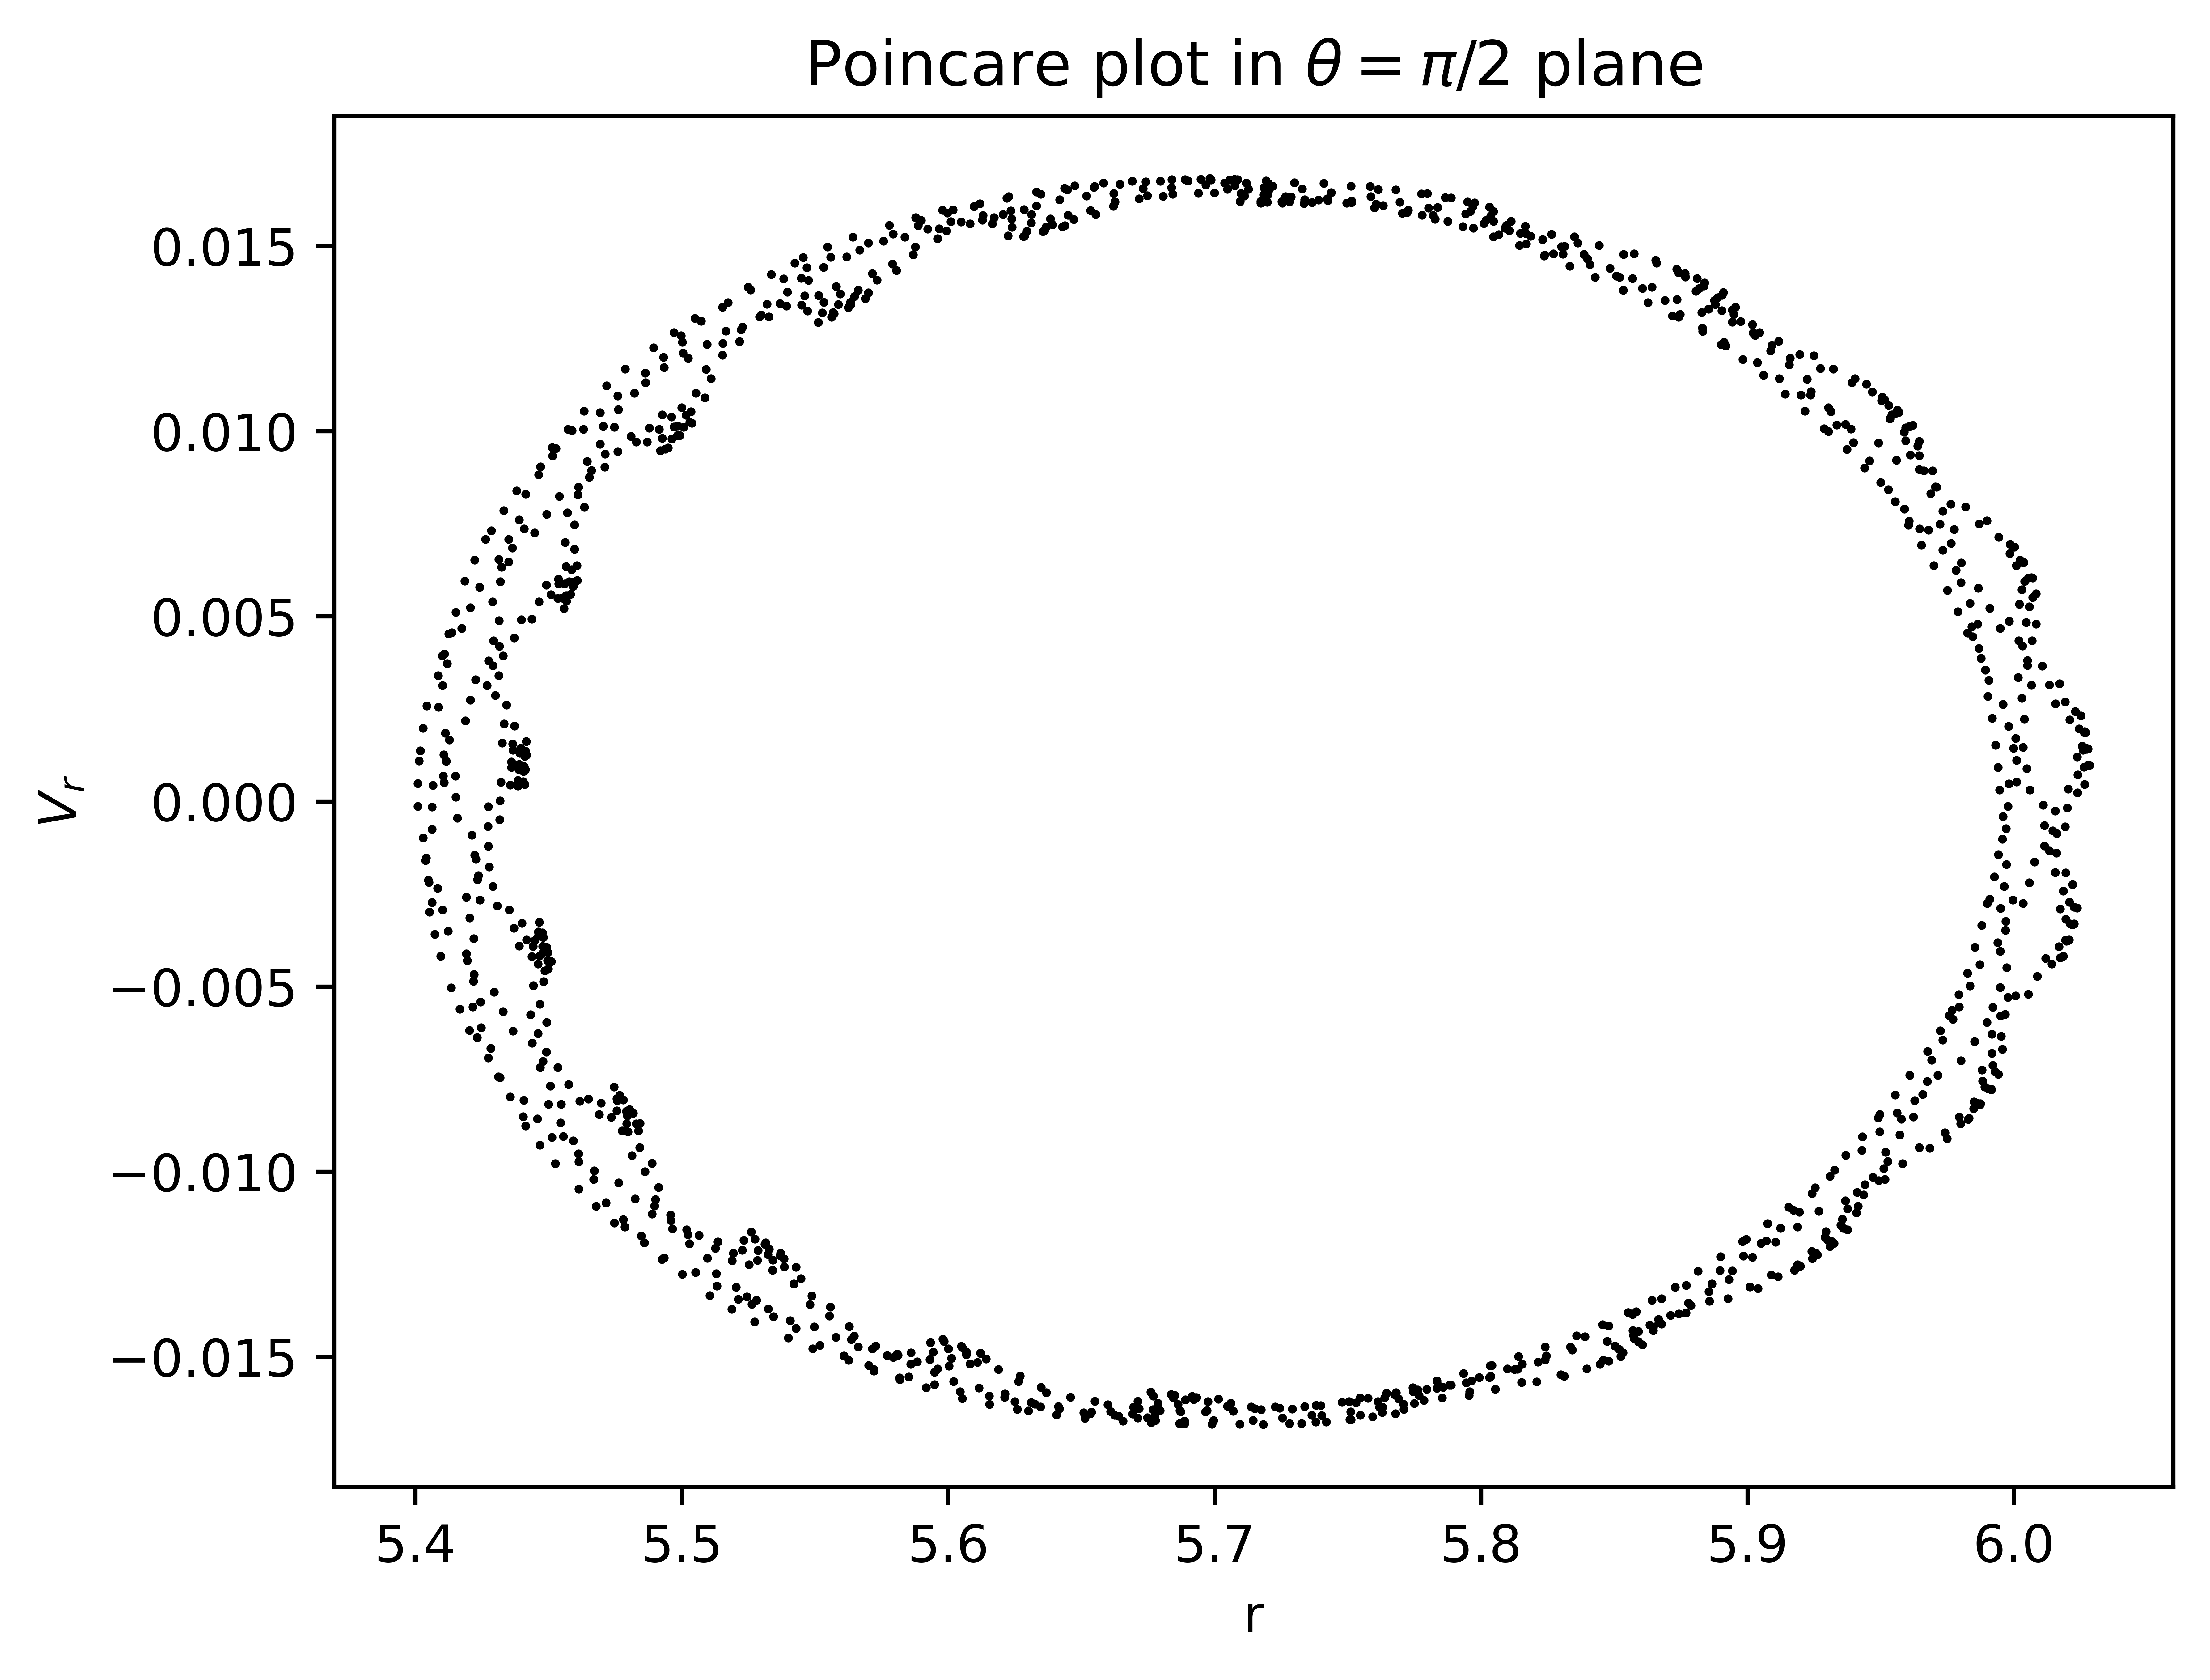

In [96]:
plt.figure(dpi=1200)
plt.scatter(poi_points[:, 1], vr, s=0.5, c="black")
plt.title(r"Poincare plot in $\theta = \pi/2$ plane")
plt.xlabel("r")
plt.ylabel(r"$V_r$")
# plt.savefig("Poincareplot_pythonS-1.png")
# plt.xlim(9,10)
# plt.ylim(-4,-3)

### Get the Derivatives of Dynamical Variables

In [97]:
@nb.njit
def Dcov_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: ll
    """
    #! Correction Added Mass term in the symbols
    dg = np.zeros((4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2
    dSt = -(a**2) *2* np.cos(theta)*np.sin(theta)
    dSr = 2 * r
    dD = 2 * (r - M)

    dg[0, 0, :] = [0.,
        2.0 * M * (-r * dSr + Sigma) / Sigma**2,
        -2.0 * M * r * dSt / Sigma**2,0.
    ]

    dg[1, 1, :] = [0.,(Delta * dSr - Sigma * dD) / Delta**2, dSt / Delta,0.]

    dg[2, 2, :] = [0.,dSr, dSt,0.]

    dg[3, 3, :] = [0.,
        (
            (a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2) * dSr
            + (-(a**2) * dD * np.sin(theta) ** 2 + 4 * r * (a**2 + r**2)) * Sigma
        )
        * np.sin(theta) ** 2
        / Sigma**2,
        (
            2
            * (-2 * a**2 * Delta * np.sin(theta) ** 2 + (a**2 + r**2) ** 2)
            * Sigma
            * np.cos(theta)
            + (a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2)
            * dSt
            * np.sin(theta)
        )
        * np.sin(theta)
        / Sigma**2,0.
    ]

    dg[0, 3, :] = [0.,
        2.0 * M * a * (r * dSr - Sigma) * np.sin(theta) ** 2 / Sigma**2,
        M
        * a
        * r
        * (-2.0 * Sigma * np.sin(2 * theta) - 1.0 * dSt * np.cos(2 * theta) + 1.0 * dSt)
        / Sigma**2,
    0.]

    dg[3, 0, :] = dg[0, 3, :]

    # return dg.asty, [[1,2]]pe(float)
    return dg

In [98]:
@nb.njit
def Dcot_metric_tensor(r, theta, a, M=1.0):
    """
    Define the metric tensor function.

    Parameters:
        a (float): Parameter 'a' in the metric.
        r (float): Parameter 'r' in the metric.
        theta (float): Parameter 'theta' in the metric.

    Returns:
        np.ndarray: The metric tensor at the given values of a, r, and theta.
        Configuration: uu
    """
    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2
    dSt = -(a**2) * np.sin(2 * theta)
    dSr = 2 * r
    dD = 2 * (r - M)

    denom = Delta * np.sin(theta) ** 2
    ddmr = dD * np.sin(theta) ** 2
    ddmt = Delta * np.sin(2 * theta)

    dg = np.zeros((4, 4, 4), dtype=type(r))

    dg[0, 0, :] = [0.,
        (
            -(a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2) * Sigma * ddmr
            - (a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2) * dSr * denom
            + (a**2 * dD * np.sin(theta) ** 2 - 4 * r * (a**2 + r**2)) * Sigma * denom
        )
        * np.sin(theta) ** 2
        / (Sigma**2 * denom**2),
        (
            -(a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2)
            * Sigma
            * ddmt
            * np.sin(theta)
            - (a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2)
            * dSt
            * denom
            * np.sin(theta)
            + 2
            * (2 * a**2 * Delta * np.sin(theta) ** 2 - (a**2 + r**2) ** 2)
            * Sigma
            * denom
            * np.cos(theta)
        )
        * np.sin(theta)
        / (Sigma**2 * denom**2),0.
    ]

    dg[1, 1, :] = [0.,
        (-Delta * dSr + Sigma * dD) / Sigma**2,
        -Delta * dSt / Sigma**2,0.
    ]

    dg[2, 2, :] = [0.,-1.0 * dSr / Sigma**2, -1.0 * dSt / Sigma**2,0.]

    dg[3, 3, :] = [0.,
        (
            (a**2 * np.sin(theta) ** 2 - Delta) * Sigma * ddmr
            + (a**2 * np.sin(theta) ** 2 - Delta) * dSr * denom
            + Sigma * dD * denom
        )
        / (Sigma**2 * denom**2),
        (
            -(a**2) * Sigma * denom * np.sin(2 * theta)
            + (a**2 * np.sin(theta) ** 2 - Delta) * Sigma * ddmt
            + (a**2 * np.sin(theta) ** 2 - Delta) * dSt * denom
        )
        / (Sigma**2 * denom**2),0.
    ]

    dg[0, 3, :] = [0.,
        2.0
        * M
        * a
        * (r * Sigma * ddmr + r * dSr * denom - Sigma * denom)
        * np.sin(theta) ** 2
        / (Sigma**2 * denom**2),
        M
        * a
        * r
        * (
            -1.0 * Sigma * ddmt * np.cos(2 * theta)
            + 1.0 * Sigma * ddmt
            - 2.0 * Sigma * denom * np.sin(2 * theta)
            - 1.0 * dSt * denom * np.cos(2 * theta)
            + 1.0 * dSt * denom
        )
        / (Sigma**2 * denom**2),0.
    ]

    dg[3, 0, :] = dg[0, 3, :]

    return dg  # return dg, [[1,2]]

In [99]:
@nb.njit
def Dkerr_christoffel(r, theta, a, M=1.0):
    """
    Function to give the christoffel symbols for kerr metric.
    The christoffel symbols are given as \Gamma ^i _{jk}

    From Reference Paper, Appendix
    Config: ull
    """

    dcs = np.zeros((4, 4, 4, 4), dtype=type(r))

    # Definitions
    Delta = a**2 - 2 * M * r + r**2
    Sigma = r**2 + a**2 * np.cos(theta) ** 2
    dSt = -(a**2) * np.sin(2 * theta)
    dSr = 2 * r
    dD = 2 * (r - M)

    dcs[3, 0, 1, :] = [0.,
        M
        * a
        * (
            (4 * r - dSr) * Delta * Sigma
            - 2 * (2 * r**2 - Sigma) * Delta * dSr
            - (2 * r**2 - Sigma) * Sigma * dD
        )
        / (Delta**2 * Sigma**3),
        M * a * (-4 * r**2 + Sigma) * dSt / (Delta * Sigma**3),0.
    ]

    dcs[0, 0, 1, :] = [0.,
        M
        * (
            2 * r * (a**2 * np.sin(theta) ** 2 + 2 * r**2) * Delta * Sigma
            + 2 * (a**2 + r**2) * (a**2 * np.cos(theta) ** 2 - r**2) * Delta * dSr
            + (a**2 + r**2) * (a**2 * np.cos(theta) ** 2 - r**2) * Sigma * dD
        )
        / (Delta**2 * Sigma**3),
        2
        * M
        * (a**2 + r**2)
        * (
            (1 / 2) * a**2 * Sigma * np.sin(2 * theta)
            + (a**2 * np.cos(theta) ** 2 - r**2) * dSt
        )
        / (Delta * Sigma**3),0.
    ]

    dcs[3, 0, 2, :] = [0.,
        2 * M * a * (2 * r * dSr - Sigma) / (Sigma**3 * np.tan(theta)),
        2
        * M
        * a
        * r
        * (Sigma + dSt * np.sin(2 * theta))
        / (Sigma**3 * np.sin(theta) ** 2),0.
    ]

    dcs[0, 0, 2, :] = [0.,
        M * a**2 * (2 * r * dSr - Sigma) * np.sin(2 * theta) / Sigma**3,
        2
        * M
        * a**2
        * r
        * (-Sigma * np.cos(2 * theta) + dSt * np.sin(2 * theta))
        / Sigma**3,0.
    ]

    dcs[0, 1, 3, :] = [0.,
        M
        * a
        * (
            2 * (2 * r**2 * (a**2 + r**2) - (a**2 - r**2) * Sigma) * Delta * dSr
            + (2 * r**2 * (a**2 + r**2) - (a**2 - r**2) * Sigma) * Sigma * dD
            - (4 * r**3 + 4 * r * (a**2 + r**2) + 2 * r * Sigma - (a**2 - r**2) * dSr)
            * Delta
            * Sigma
        )
        * np.sin(theta) ** 2
        / (Delta**2 * Sigma**3),
        M
        * a
        * (
            2 * (2 * r**2 * (a**2 + r**2) - (a**2 - r**2) * Sigma) * dSt * np.sin(theta)
            + (
                (a**2 - r**2) * dSt * np.sin(theta)
                + (-4 * r**2 * (a**2 + r**2) + 2 * (a**2 - r**2) * Sigma)
                * np.cos(theta)
            )
            * Sigma
        )
        * np.sin(theta)
        / (Delta * Sigma**3),0.
    ]

    dcs[3, 1, 3, :] = [0.,
        (
            2
            * (
                M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2
                + r * (2 * M * r - Sigma) * Sigma
            )
            * Delta
            * dSr
            + (
                M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2
                + r * (2 * M * r - Sigma) * Sigma
            )
            * Sigma
            * dD
            - (
                M * a**2 * (4 * r - dSr) * np.sin(theta) ** 2
                + r * (2 * M - dSr) * Sigma
                + r * (2 * M * r - Sigma) * dSr
                + (2 * M * r - Sigma) * Sigma
            )
            * Delta
            * Sigma
        )
        / (Delta**2 * Sigma**3),
        M
        * (
            -2 * a**2 * r**2 * Sigma * np.sin(2 * theta)
            + 4 * a**2 * r**2 * dSt * np.sin(theta) ** 2
            + a**2 * Sigma**2 * np.sin(2 * theta)
            - a**2 * Sigma * dSt * np.sin(theta) ** 2
            + 2 * r**2 * Sigma * dSt
        )
        / (Delta * Sigma**3),0.
    ]

    dcs[0, 2, 3, :] = [0.,
        2
        * M
        * a**3
        * (-2 * r * dSr + Sigma)
        * np.sin(theta) ** 3
        * np.cos(theta)
        / Sigma**3,
        2
        * M
        * a**3
        * r
        * (Sigma * np.sin(3 * theta) - dSt * np.sin(theta) * np.sin(2 * theta))
        * np.sin(theta)
        / Sigma**3,0.
    ]

    dcs[3, 2, 3, :] = [0.,
        M * a**2 * (-2 * r * dSr + Sigma) * np.sin(2 * theta) / Sigma**3,
        2 * M * a**2 * r * np.cos(2 * theta) / Sigma**2
        - 2 * M * a**2 * r * dSt * np.sin(2 * theta) / Sigma**3
        + 2 / (np.cos(2 * theta) - 1),0.
    ]

    dcs[1, 0, 0, :] = [0.,
        M
        * (
            -3 * (2 * r**2 - Sigma) * Delta * dSr
            + ((4 * r - dSr) * Delta + (2 * r**2 - Sigma) * dD) * Sigma
        )
        / Sigma**4,
        2 * M * (-3 * r**2 + Sigma) * Delta * dSt / Sigma**4,0.
    ]

    dcs[1, 0, 3, :] = [0.,
        M
        * a
        * (
            3 * (2 * r**2 - Sigma) * Delta * dSr
            - ((4 * r - dSr) * Delta + (2 * r**2 - Sigma) * dD) * Sigma
        )
        * np.sin(theta) ** 2
        / Sigma**4,
        M
        * a
        * (
            3 * (2 * r**2 - Sigma) * dSt * np.sin(theta)
            + ((-4 * r**2 + 2 * Sigma) * np.cos(theta) + dSt * np.sin(theta)) * Sigma
        )
        * Delta
        * np.sin(theta)
        / Sigma**4,0.
    ]

    dcs[2, 0, 0, :] = [0.,
        M * a**2 * (3 * r * dSr - Sigma) * np.sin(2 * theta) / Sigma**4,
        M
        * a**2
        * r
        * (-2 * Sigma * np.cos(2 * theta) + 3 * dSt * np.sin(2 * theta))
        / Sigma**4,0.
    ]

    dcs[2, 0, 3, :] = [0.,
        (1 / 2)
        * M
        * a
        * (-6.0 * r * (a**2 + r**2) * dSr + (2.0 * a**2 + 6.0 * r**2) * Sigma)
        * np.sin(2 * theta)
        / Sigma**4,
        M
        * a
        * r
        * (a**2 + r**2)
        * (2.0 * Sigma * np.cos(2 * theta) - 3.0 * dSt * np.sin(2 * theta))
        / Sigma**4,0.
    ]

    dcs[1, 1, 1, :] = [0.,
        -M * dD / Delta**2
        - r * dSr / Sigma**2
        + r * dD / Delta**2
        + 1 / Sigma
        - 1 / Delta,
        -r * dSt / Sigma**2,0.
    ]

    dcs[1, 2, 2, :] = [0.,
        (r * Delta * dSr - (r * dD + Delta) * Sigma) / Sigma**2,
        r * Delta * dSt / Sigma**2,0.
    ]

    dcs[2, 1, 2, :] = [0.,(-r * dSr + Sigma) / Sigma**2, -r * dSt / Sigma**2,0.]

    dcs[1, 1, 2, :]= dcs[2, 2, 2, :]= [0.,
        (1 / 2) * a**2 * dSr * np.sin(2 * theta) / Sigma**2,
        a**2
        * (-Sigma * np.cos(2 * theta) + (1 / 2) * dSt * np.sin(2 * theta))
        / Sigma**2,0.
    ]

    dcs[2, 1, 1, :] = [0.,
        (1 / 2)
        * a**2
        * (-Delta * dSr - Sigma * dD)
        * np.sin(2 * theta)
        / (Delta**2 * Sigma**2),
        a**2
        * (Sigma * np.cos(2 * theta) - 1 / 2 * dSt * np.sin(2 * theta))
        / (Delta * Sigma**2),0.
    ]

    dcs[1, 3, 3, :] = [0.,
        (
            (
                (M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2 - r * Sigma**2) * dD
                - (
                    -M * a**2 * (4 * r - dSr) * np.sin(theta) ** 2
                    + 2 * r * Sigma * dSr
                    + Sigma**2
                )
                * Delta
            )
            * Sigma
            - 3
            * (M * a**2 * (2 * r**2 - Sigma) * np.sin(theta) ** 2 - r * Sigma**2)
            * Delta
            * dSr
        )
        * np.sin(theta) ** 2
        / Sigma**4,
        (
            -3 / 2 * M * a**2 * r**2 * (1 - np.cos(2 * theta)) ** 2 * dSt
            + 2 * M * a**2 * r**2 * Sigma * np.sin(2 * theta)
            - M * a**2 * r**2 * Sigma * np.sin(4 * theta)
            + (1 / 2) * M * a**2 * (1 - np.cos(2 * theta)) ** 2 * Sigma * dSt
            - M * a**2 * Sigma**2 * np.sin(2 * theta)
            + (1 / 2) * M * a**2 * Sigma**2 * np.sin(4 * theta)
            - r * Sigma**3 * np.sin(2 * theta)
            - 1 / 2 * r * Sigma**2 * dSt * np.cos(2 * theta)
            + (1 / 2) * r * Sigma**2 * dSt
        )
        * Delta
        / Sigma**4,0.
    ]

    dcs[2, 3, 3, :] = [0.,
        (1 / 2)
        * (
            3 * (2 * M * r * (a**2 + r**2) ** 2 + Delta * Sigma**2) * dSr
            - (
                8 * M * r**2 * (a**2 + r**2)
                + 2 * M * (a**2 + r**2) ** 2
                + 2 * Delta * Sigma * dSr
                + Sigma**2 * dD
            )
            * Sigma
        )
        * np.sin(2 * theta)
        / Sigma**4,
        -2 * M * r * (a**2 + r**2) ** 2 * np.cos(2 * theta) / Sigma**3
        + 3 * M * r * (a**2 + r**2) ** 2 * dSt * np.sin(2 * theta) / Sigma**4
        - Delta * np.cos(2 * theta) / Sigma
        + (1 / 2) * Delta * dSt * np.sin(2 * theta) / Sigma**2,0.
    ]

    dcs[0, 1, 0, :] = dcs[0, 0, 1, :]
    dcs[0, 2, 0, :] = dcs[0, 0, 2, :]
    dcs[0, 3, 1, :] = dcs[0, 1, 3, :]
    dcs[0, 3, 2, :] = dcs[0, 2, 3, :]

    dcs[1, 3, 0, :] = dcs[1, 0, 3, :]
    dcs[1, 2, 1, :] = dcs[1, 1, 2, :]

    dcs[2, 3, 0, :] = dcs[2, 0, 3, :]
    dcs[2, 2, 1, :] = dcs[2, 1, 2, :]

    dcs[3, 1, 0, :] = dcs[3, 0, 1, :]
    dcs[3, 2, 0, :] = dcs[3, 0, 2, :]
    dcs[3, 3, 1, :] = dcs[3, 1, 3, :]
    dcs[3, 3, 2, :] = dcs[3, 2, 3, :]

    # return symmetrize(arr=dcs)+np.zer, [[1,2]]os((4,4,4))
    return dcs + np.zeros((4, 4, 4, 4))
    # return dcs, [[1,2]]

In [100]:
@nb.njit
def DRijkl(r,theta,a, M=1.0, config="ullll"):

    drijkl= np.zeros((4,4,4,4,4),dtype=type(r))

    Delta=  a**2 - 2 * M * r + r**2
    Sigma =  r**2 + a**2 * np.cos(theta) ** 2
    dSt= -a**2*np.sin(2*theta)
    dSr=  2*r
    dD=  2*(r-M)

    drijkl[0, 0, 0, 3, :] = [0, M**2*a*r*(8.0*r*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + 4.0*(-3.0*a**2*np.cos(theta)**2 + 2.0*r**2)*Sigma)*np.sin(theta)**2/Sigma**5, M**2*a*r**2*(-3.0*a**2*Sigma*np.sin(4*theta) - 3.0*a**2*dSt*np.cos(4*theta) + 3.0*a**2*dSt + 2.0*r**2*Sigma*np.sin(2*theta) + 4.0*r**2*dSt*np.cos(2*theta) - 4.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[0, 0, 1, 2, :] = [0, M**2*a**2*(-6.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr - 2.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Sigma*dD + (2.0*a**2*np.cos(theta)**2 - 18.0*r**2)*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M**2*a**2*r*(-6.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (8.0*a**2*np.sin(theta)**4 - 10.0*a**2*np.sin(theta)**2 + 2.0*a**2 + 12.0*r**2*np.sin(theta)**2 - 6.0*r**2)*Sigma)/(Delta*Sigma**4), 0.]

    drijkl[0, 1, 0, 1, :] = [0, M*(3*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*Delta*dSr + r*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*Sigma*dD + (3.0*a**4*np.sin(theta)**4 + 3.0*a**4*np.sin(theta)**2 - 6.0*a**4 + 21.0*a**2*r**2*np.sin(theta)**2 - 12.0*a**2*r**2 + 10.0*r**4)*Delta*Sigma)/(Delta**2*Sigma**4), M*r*(a**2*(12.0*a**2*np.sin(theta)**2 + 6.0*a**2 + 14.0*r**2)*Sigma*np.sin(theta)*np.cos(theta) + 3*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSt)/(Delta*Sigma**4), 0.]

    drijkl[0, 1, 0, 2, :] = [0, M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(-2*M*r + 3.0*a**2 + 3.0*r**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(-2*M*r + 3.0*a**2 + 3.0*r**2)*Sigma*dD + (-6.0*r*(-2*M*r + 3.0*a**2 + 3.0*r**2) + (-2*M + 6.0*r)*(a**2*np.cos(theta)**2 - 3.0*r**2))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)*(-2*M*r + 3.0*a**2 + 3.0*r**2)/(Delta*Sigma**4), 0.]

    drijkl[0, 1, 1, 3, :] = [0, M*a*(9.0*r*(a**2 + r**2)*(3.0*a**2*np.cos(theta)**2 - r**2)*Delta*dSr + 3.0*r*(a**2 + r**2)*(3.0*a**2*np.cos(theta)**2 - r**2)*Sigma*dD + (-9.0*a**4*np.cos(theta)**2 - 27.0*a**2*r**2*np.cos(theta)**2 + 9.0*a**2*r**2 + 15.0*r**4)*Delta*Sigma)*np.sin(theta)**2/(Delta**2*Sigma**4), M*a*r*(a**2 + r**2)*(-4.5*a**2*Sigma*np.sin(4*theta) - 3.375*a**2*dSt*np.cos(4*theta) + 3.375*a**2*dSt + 3.0*r**2*Sigma*np.sin(2*theta) + 4.5*r**2*dSt*np.cos(2*theta) - 4.5*r**2*dSt)/(Delta*Sigma**4), 0.]

    drijkl[0, 1, 2, 3, :] = [0., M*a*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*Sigma*dD + (-6.0*r*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2) + (a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*dD*np.sin(theta)**2 + 8.0*r*(a**2 + r**2)))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a*(2*a**2*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*Sigma*np.sin(theta)**2*np.cos(theta)**2 - 3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*dSt*np.sin(theta)*np.cos(theta) + (a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*(4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)/(Delta*Sigma**4), 0.]

    # Antisymmetric under exchange of last two indices.
    drijkl[0, 0, 3, 0, :] = -drijkl[0, 0, 0, 3, :]
    drijkl[0, 0, 2, 1, :] = -drijkl[0, 0, 1, 2, :]
    drijkl[0, 1, 1, 0, :] = -drijkl[0, 1, 0, 1, :]
    drijkl[0, 1, 2, 0, :] = -drijkl[0, 1, 0, 2, :]
    drijkl[0, 1, 3, 1, :] = -drijkl[0, 1, 1, 3, :]
    drijkl[0, 1, 3, 2, :] = -drijkl[0, 1, 2, 3, :]

    #! -------------------------------------------------------------------------------------#

    drijkl[0, 2, 0, 1, :] = [0., M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(-4*M*r + 3.0*a**2 + 3.0*r**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(-4*M*r + 3.0*a**2 + 3.0*r**2)*Sigma*dD + (-6.0*r*(-4*M*r + 3.0*a**2 + 3.0*r**2) + (-4*M + 6.0*r)*(a**2*np.cos(theta)**2 - 3.0*r**2))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)*(-4*M*r + 3.0*a**2 + 3.0*r**2)/(Delta*Sigma**4), 0.]

    drijkl[0, 2, 0, 2, :] = [0., M*(-3*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(2*a**2*np.sin(theta)**2 + a**2 + r**2)*dSr + (-6.0*a**4*np.sin(theta)**4 + 3.0*a**4*np.sin(theta)**2 + 3.0*a**4 - 15.0*a**2*r**2*np.sin(theta)**2 + 6.0*a**2*r**2 - 5.0*r**4)*Sigma)/Sigma**4, M*r*(a**2*(-24.0*a**2*np.sin(theta)**2 + 6.0*a**2 - 10.0*r**2)*Sigma*np.sin(theta)*np.cos(theta) - 3*(3.0*a**2*np.cos(theta)**2 - r**2)*(2*a**2*np.sin(theta)**2 + a**2 + r**2)*dSt)/Sigma**4, 0.]

    drijkl[0, 2, 1, 3, :] = [0., M*a*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*Sigma*dD + (-6.0*r*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2) + (a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*dD*np.sin(theta)**2 + 4*r*(a**2 + r**2)))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a*(4.0*a**2*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*Sigma*np.sin(theta)**2*np.cos(theta)**2 - 3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*dSt*np.sin(theta)*np.cos(theta) + (2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*(4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)/(Delta*Sigma**4), 0.]

    drijkl[0, 2, 2, 3, :] = [0., M*a*(-9.0*r*(a**2 + r**2)*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + (9.0*a**4*np.cos(theta)**2 + 27.0*a**2*r**2*np.cos(theta)**2 - 9.0*a**2*r**2 - 15.0*r**4)*Sigma)*np.sin(theta)**2/Sigma**4, M*a*r*(a**2 + r**2)*(4.5*a**2*Sigma*np.sin(4*theta) + 3.375*a**2*dSt*np.cos(4*theta) - 3.375*a**2*dSt - 3.0*r**2*Sigma*np.sin(2*theta) - 4.5*r**2*dSt*np.cos(2*theta) + 4.5*r**2*dSt)/Sigma**4, 0.]

    drijkl[0, 3, 0, 3, :] = [0., M*(-4*r*(-3*a**2*np.cos(theta)**2 + r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*dSr + (2*r**2*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2) + r*(-3*a**2*np.cos(theta)**2 + r**2)*(a**2*dD*np.sin(theta)**2 - 4*r*(a**2 + r**2)) + (-3*a**2*np.cos(theta)**2 + r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2))*Sigma)*np.sin(theta)**2/Sigma**5, 2*M*r*(-2*(-3*a**2*np.cos(theta)**2 + r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*dSt*np.sin(theta) + (a**2*(-3*a**2*np.cos(theta)**2 + r**2)*Delta*np.sin(theta)**2 + 3*a**2*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*np.sin(theta)**2 + (-3*a**2*np.cos(theta)**2 + r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2))*Sigma*np.cos(theta))*np.sin(theta)/Sigma**5, 0.]

    drijkl[0, 3, 1, 2, :] = [0., M*a*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*Sigma*dD + (-6.0*r*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2) + (a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*dD*np.sin(theta)**2 - 4*r*(a**2 + r**2)))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a*(2*a**2*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*Sigma*np.sin(theta)**2*np.cos(theta)**2 - 3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*dSt*np.sin(theta)*np.cos(theta) + (a**2*Delta*np.sin(theta)**2 - (a**2 + r**2)**2)*(4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)/(Delta*Sigma**4), 0.]

    # Symmetries
    drijkl[0, 2, 1, 0, :] = -drijkl[0, 2, 0, 1, :]
    drijkl[0, 2, 2, 0, :] = -drijkl[0, 2, 0, 2, :]
    drijkl[0, 2, 3, 1, :] = -drijkl[0, 2, 1, 3, :]
    drijkl[0, 2, 3, 2, :] = -drijkl[0, 2, 2, 3, :]
    drijkl[0, 3, 3, 0, :] = -drijkl[0, 3, 0, 3, :]
    drijkl[0, 3, 2, 1, :] = -drijkl[0, 3, 1, 2, :]

    #! ------------------------------------------------------------------------------#

    drijkl[1, 0, 0, 1, :] = [0., M*(4*r*(a**2*np.sin(theta)**2 + 2.0*Delta)*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + (2*r**2*(a**2*np.sin(theta)**2 + 2.0*Delta) - 2.0*r*(3.0*a**2*np.cos(theta)**2 - r**2)*dD - (a**2*np.sin(theta)**2 + 2.0*Delta)*(3.0*a**2*np.cos(theta)**2 - r**2))*Sigma)/Sigma**5, M*r*(a**2*(12.0*a**2*np.sin(theta)**2 - 6.0*a**2 + 2.0*r**2 + 12.0*Delta)*Sigma*np.sin(theta)*np.cos(theta) + 4*(a**2*np.sin(theta)**2 + 2.0*Delta)*(3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/Sigma**5, 0.]

    drijkl[1, 0, 0, 2, :] = [0., M*a**2*(-12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr + (-18.0*r*Delta + 3.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Sigma)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a**2*(-12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (12.0*a**2*np.sin(theta)**4 - 15.0*a**2*np.sin(theta)**2 + 3.0*a**2 + 18.0*r**2*np.sin(theta)**2 - 9.0*r**2)*Sigma)*Delta/Sigma**5, 0.]

    drijkl[1, 0, 1, 3, :] = [0., M*a*(4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*dSr + (r**2*(-8.0*M*r + 6.0*a**2 + 6.0*r**2) + r*(4.0*M - 6.0*r)*(3.0*a**2*np.cos(theta)**2 - r**2) + (3.0*a**2*np.cos(theta)**2 - r**2)*(4.0*M*r - 3.0*a**2 - 3.0*r**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*a*r*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*(-1.5*a**2*Sigma*np.sin(4*theta) - 1.5*a**2*dSt*np.cos(4*theta) + 1.5*a**2*dSt + r**2*Sigma*np.sin(2*theta) + 2.0*r**2*dSt*np.cos(2*theta) - 2.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[1, 0, 2, 3, :] = [0., M*a*(-4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*Delta*dSr + (4.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta - 6.0*r*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*Delta + (a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dD)*Sigma)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a*(-4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (6.0*a**4*np.sin(theta)**6 - 1.0*a**4*np.sin(theta)**4 - 7.0*a**4*np.sin(theta)**2 + 2.0*a**4 + 20.0*a**2*r**2*np.sin(theta)**4 - 7.0*a**2*r**2*np.sin(theta)**2 - 4.0*a**2*r**2 + 12.0*r**4*np.sin(theta)**2 - 6.0*r**4)*Sigma)*Delta/Sigma**5, 0.]

    drijkl[1, 2, 0, 3, :] = [0., M*a*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr + (-6.0*r*Delta + (a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Sigma)*np.sin(theta)*np.cos(theta)/Sigma**4, M*a*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)*Delta/Sigma**4, 0.]

    drijkl[1, 2, 1, 2, :] = [0., M*(-2*r*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + 3.0*(a**2*np.cos(theta)**2 - r**2)*Sigma)/Sigma**3, M*r*(-3.0*a**2*Sigma*np.sin(2*theta) - 2*(3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/Sigma**3, 0.]

    drijkl[1, 3, 0, 1, :] = [0., M*a*(-4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*dSr + (r**2*(8.0*M*r - 6.0*a**2 - 6.0*r**2) - r*(4.0*M - 6.0*r)*(3.0*a**2*np.cos(theta)**2 - r**2) + (3.0*a**2*np.cos(theta)**2 - r**2)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*a*r*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*(1.5*a**2*Sigma*np.sin(4*theta) + 1.5*a**2*dSt*np.cos(4*theta) - 1.5*a**2*dSt - 1.0*r**2*Sigma*np.sin(2*theta) - 2.0*r**2*dSt*np.cos(2*theta) + 2.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[1, 3, 0, 2, :] = [0., M*a*(4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*Delta*dSr + (-2*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta + 6.0*r*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*Delta - (a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*dD)*Sigma)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a*(4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*dSt*np.sin(theta)*np.cos(theta) + (-12.0*a**4*np.sin(theta)**6 + 14.0*a**4*np.sin(theta)**4 - 1.0*a**4*np.sin(theta)**2 - 1.0*a**4 - 28.0*a**2*r**2*np.sin(theta)**4 + 17.0*a**2*r**2*np.sin(theta)**2 + 2.0*a**2*r**2 - 6.0*r**4*np.sin(theta)**2 + 3.0*r**4)*Sigma)*Delta/Sigma**5, 0.]

    drijkl[1, 3, 1, 3, :] = [0., M*(-4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*dSr + (-2*r**2*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2) + r*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*dD*np.sin(theta)**2 + 4*r*(a**2 + r**2)) + (3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*r*(-4*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*dSt*np.sin(theta) + (4.0*a**2*(3.0*a**2*np.cos(theta)**2 - r**2)*Delta*np.sin(theta)**2 - 6.0*a**2*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2)*np.sin(theta)**2 + 2*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*Delta*np.sin(theta)**2 + (a**2 + r**2)**2))*Sigma*np.cos(theta))*np.sin(theta)/Sigma**5, 0.]

    drijkl[1, 3, 2, 3, :] = [0., M*a**2*(12.0*(a**2 + r**2)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr + (18.0*r*(a**2 + r**2)*Delta - 6.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta - 3.0*(a**2 + r**2)*(a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Sigma)*np.sin(theta)**3*np.cos(theta)/Sigma**5, M*a**2*(a**2 + r**2)*(12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (-18.0*a**2*np.sin(theta)**4 + 27.0*a**2*np.sin(theta)**2 - 9.0*a**2 - 36.0*r**2*np.sin(theta)**2 + 27.0*r**2)*Sigma)*Delta*np.sin(theta)**2/Sigma**5, 0.]

    # Symmetries
    drijkl[1, 0, 1, 0, :] = -drijkl[1, 0, 0, 1, :]
    drijkl[1, 0, 2, 0, :] = -drijkl[1, 0, 0, 2, :]
    drijkl[1, 0, 3, 1, :] = -drijkl[1, 0, 1, 3, :]
    drijkl[1, 0, 3, 2, :] = -drijkl[1, 0, 2, 3, :]
    drijkl[1, 2, 3, 0, :] = -drijkl[1, 2, 0, 3, :]
    drijkl[1, 2, 2, 1, :] = -drijkl[1, 2, 1, 2, :]
    drijkl[1, 3, 1, 0, :] = -drijkl[1, 3, 0, 1, :]
    drijkl[1, 3, 2, 0, :] = -drijkl[1, 3, 0, 2, :]
    drijkl[1, 3, 3, 1, :] = -drijkl[1, 3, 1, 3, :]
    drijkl[1, 3, 3, 2, :] = -drijkl[1, 3, 2, 3, :]

    #! -------------------------------------------------------------------------------------#

    drijkl[2, 0, 0, 1, :] = [0., M*a**2*(-18.0*r*Sigma - 12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSr)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a**2*(-12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (12.0*a**2*np.sin(theta)**4 - 15.0*a**2*np.sin(theta)**2 + 3.0*a**2 + 18.0*r**2*np.sin(theta)**2 - 9.0*r**2)*Sigma)/Sigma**5, 0.] 

    drijkl[2, 0, 0, 2, :] = [0., M*(-4*r*(2.0*a**2*np.sin(theta)**2 + Delta)*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + (-2*r**2*(2.0*a**2*np.sin(theta)**2 + Delta) + r*(3.0*a**2*np.cos(theta)**2 - r**2)*dD + (2.0*a**2*np.sin(theta)**2 + Delta)*(3.0*a**2*np.cos(theta)**2 - r**2))*Sigma)/Sigma**5, M*r*(a**2*(-24.0*a**2*np.sin(theta)**2 + 12.0*a**2 - 4.0*r**2 - 6.0*Delta)*Sigma*np.sin(theta)*np.cos(theta) - 4*(2.0*a**2*np.sin(theta)**2 + Delta)*(3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/Sigma**5, 0.]

    drijkl[2, 0, 1, 3, :] = [0., M*a*(r*(14.0*a**2*np.cos(theta)**2 - 18.0*a**2 - 12.0*r**2)*Sigma - 4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*dSr)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a*(-4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*dSt*np.sin(theta)*np.cos(theta) + (12.0*a**4*np.sin(theta)**6 - 14.0*a**4*np.sin(theta)**4 + 1.0*a**4*np.sin(theta)**2 + 1.0*a**4 + 28.0*a**2*r**2*np.sin(theta)**4 - 17.0*a**2*r**2*np.sin(theta)**2 - 2.0*a**2*r**2 + 6.0*r**4*np.sin(theta)**2 - 3.0*r**4)*Sigma)/Sigma**5, 0.]

    drijkl[2, 0, 2, 3, :] = [0., M*a*(-4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*dSr + (r**2*(4.0*M*r - 6.0*a**2 - 6.0*r**2) - r*(2.0*M - 6.0*r)*(3.0*a**2*np.cos(theta)**2 - r**2) + (3.0*a**2*np.cos(theta)**2 - r**2)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*a*r*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*(1.5*a**2*Sigma*np.sin(4*theta) + 1.5*a**2*dSt*np.cos(4*theta) - 1.5*a**2*dSt - 1.0*r**2*Sigma*np.sin(2*theta) - 2.0*r**2*dSt*np.cos(2*theta) + 2.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[2, 1, 0, 3, :] = [0., M*a*(6.0*r*Sigma + 3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSr)*np.sin(theta)*np.cos(theta)/Sigma**4, M*a*(3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (-4.0*a**2*np.sin(theta)**4 + 5.0*a**2*np.sin(theta)**2 - 1.0*a**2 - 6.0*r**2*np.sin(theta)**2 + 3.0*r**2)*Sigma)/Sigma**4, 0.]

    drijkl[2, 1, 1, 2, :] = [0., M*(2*r*(3.0*a**2*np.cos(theta)**2 - r**2)*Delta*dSr + r*(3.0*a**2*np.cos(theta)**2 - r**2)*Sigma*dD + 3.0*(-a**2*np.cos(theta)**2 + r**2)*Delta*Sigma)/(Delta**2*Sigma**3), M*r*(3.0*a**2*Sigma*np.sin(2*theta) + 2*(3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/(Delta*Sigma**3), 0.]

    drijkl[2, 3, 0, 1, :] = [0., M*a*(r*(10.0*a**2*np.sin(theta)**2 + 8.0*a**2 + 24.0*r**2)*Sigma + 4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSr)*np.sin(theta)*np.cos(theta)/Sigma**5, M*a*(4*(a**2*np.cos(theta)**2 - 3.0*r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (-6.0*a**4*np.sin(theta)**6 + 1.0*a**4*np.sin(theta)**4 + 7.0*a**4*np.sin(theta)**2 - 2.0*a**4 - 20.0*a**2*r**2*np.sin(theta)**4 + 7.0*a**2*r**2*np.sin(theta)**2 + 4.0*a**2*r**2 - 12.0*r**4*np.sin(theta)**2 + 6.0*r**4)*Sigma)/Sigma**5, 0.]

    drijkl[2, 3, 0, 2, :] = [0., M*a*(4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*dSr + (r**2*(-4.0*M*r + 6.0*a**2 + 6.0*r**2) + r*(2.0*M - 6.0*r)*(3.0*a**2*np.cos(theta)**2 - r**2) + (3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*M*r - 3.0*a**2 - 3.0*r**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*a*r*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*(-1.5*a**2*Sigma*np.sin(4*theta) - 1.5*a**2*dSt*np.cos(4*theta) + 1.5*a**2*dSt + r**2*Sigma*np.sin(2*theta) + 2.0*r**2*dSt*np.cos(2*theta) - 2.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[2, 3, 1, 3, :] = [0., M*a**2*(r*(-6.0*a**2*np.cos(theta)**2 + 18.0*a**2 + 36.0*r**2)*Sigma + 12.0*(a**2 + r**2)*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSr)*np.sin(theta)**3*np.cos(theta)/Sigma**5, M*a**2*(a**2 + r**2)*(12.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (-18.0*a**2*np.sin(theta)**4 + 27.0*a**2*np.sin(theta)**2 - 9.0*a**2 - 36.0*r**2*np.sin(theta)**2 + 27.0*r**2)*Sigma)*np.sin(theta)**2/Sigma**5, 0.]

    drijkl[2, 3, 2, 3, :] = [0., M*(4*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*dSr + (2*r**2*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2) - r*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*dD*np.sin(theta)**2 + 8.0*r*(a**2 + r**2)) - (3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2))*Sigma)*np.sin(theta)**2/Sigma**5, M*r*(4*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*dSt*np.sin(theta) + (-2*a**2*(3.0*a**2*np.cos(theta)**2 - r**2)*Delta*np.sin(theta)**2 + 6.0*a**2*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2)*np.sin(theta)**2 - 2*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*Delta*np.sin(theta)**2 + 2.0*(a**2 + r**2)**2))*Sigma*np.cos(theta))*np.sin(theta)/Sigma**5, 0.]

    # Symmetries
    drijkl[2, 0, 1, 0, :] = -drijkl[2, 0, 0, 1, :]
    drijkl[2, 0, 2, 0, :] = -drijkl[2, 0, 0, 2, :]
    drijkl[2, 0, 3, 1, :] = -drijkl[2, 0, 1, 3, :]
    drijkl[2, 0, 3, 2, :] = -drijkl[2, 0, 2, 3, :]
    drijkl[2, 1, 3, 0, :] = -drijkl[2, 1, 0, 3, :]
    drijkl[2, 1, 2, 1, :] = -drijkl[2, 1, 1, 2, :]
    drijkl[2, 3, 1, 0, :] = -drijkl[2, 3, 0, 1, :]
    drijkl[2, 3, 2, 0, :] = -drijkl[2, 3, 0, 2, :]
    drijkl[2, 3, 3, 1, :] = -drijkl[2, 3, 1, 3, :]
    drijkl[2, 3, 3, 2, :] = -drijkl[2, 3, 2, 3, :]

    #! --------------------------------------------------------------------------#

    drijkl[3, 0, 1, 2, :] = [0., M*a*(-3*(a**2*np.sin(theta)**2 - Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr - (a**2*np.sin(theta)**2 - Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Sigma*dD + (-6.0*r*(a**2*np.sin(theta)**2 - Delta) - (a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Delta*Sigma)/(Delta**2*Sigma**4*np.tan(theta)), M*a*(1.0*a**4*(1 - np.cos(2*theta))**2*Sigma + 2.5*a**4*Sigma*np.cos(2*theta) - 1.5*a**4*Sigma - 0.75*a**4*dSt*np.sin(2*theta) - 0.375*a**4*dSt*np.sin(4*theta) - 3.0*a**2*r**2*Sigma*np.cos(2*theta) + 4.5*a**2*r**2*dSt*np.sin(2*theta) + 1.0*a**2*Delta*Sigma*np.cos(2*theta) - 1.5*a**2*Delta*dSt*np.sin(2*theta) + 3.0*a**2*Delta*dSt/np.tan(theta) + 2.0*a**2*Delta*Sigma/(1 - np.cos(2*theta)) - 3.0*r**2*Delta*Sigma/np.sin(theta)**2 - 9.0*r**2*Delta*dSt/np.tan(theta))/(Delta*Sigma**4), 0.]

    drijkl[3, 1, 0, 1, :] = [0., M*a*(9.0*r*(3.0*a**2*np.cos(theta)**2 - r**2)*Delta*dSr + 3.0*r*(3.0*a**2*np.cos(theta)**2 - r**2)*Sigma*dD + 9.0*(-a**2*np.cos(theta)**2 + r**2)*Delta*Sigma)/(Delta**2*Sigma**4), 9.0*M*a*r*(a**2*Sigma*np.sin(2*theta) + (3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/(Delta*Sigma**4), 0.]

    drijkl[3, 1, 0, 2, :] = [0., M*a*(-3*(2.0*a**2*np.sin(theta)**2 + Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr - (2.0*a**2*np.sin(theta)**2 + Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Sigma*dD + (-6.0*r*(2.0*a**2*np.sin(theta)**2 + Delta) + (a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Delta*Sigma)/(Delta**2*Sigma**4*np.tan(theta)), M*a*(2.0*a**4*(1 - np.cos(2*theta))**2*Sigma + 5.0*a**4*Sigma*np.cos(2*theta) - 3.0*a**4*Sigma - 1.5*a**4*dSt*np.sin(2*theta) - 0.75*a**4*dSt*np.sin(4*theta) - 6.0*a**2*r**2*Sigma*np.cos(2*theta) + 9.0*a**2*r**2*dSt*np.sin(2*theta) - 1.0*a**2*Delta*Sigma*np.cos(2*theta) + 1.5*a**2*Delta*dSt*np.sin(2*theta) - 3.0*a**2*Delta*dSt/np.tan(theta) - 2.0*a**2*Delta*Sigma/(1 - np.cos(2*theta)) + 3.0*r**2*Delta*Sigma/np.sin(theta)**2 + 9.0*r**2*Delta*dSt/np.tan(theta))/(Delta*Sigma**4), 0.]

    drijkl[3, 1, 1, 3, :] = [0., M*(3*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*Delta*dSr + r*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*Sigma*dD + (6.0*a**4*np.sin(theta)**4 - 3.0*a**4*np.sin(theta)**2 - 3.0*a**4 + 15.0*a**2*r**2*np.sin(theta)**2 - 6.0*a**2*r**2 + 5.0*r**4)*Delta*Sigma)/(Delta**2*Sigma**4), M*r*(a**2*(24.0*a**2*np.sin(theta)**2 - 6.0*a**2 + 10.0*r**2)*Sigma*np.sin(theta)*np.cos(theta) + 3*(3.0*a**2*np.cos(theta)**2 - r**2)*(2.0*a**2*np.sin(theta)**2 + a**2 + r**2)*dSt)/(Delta*Sigma**4), 0.]

    drijkl[3, 1, 2, 3, :] = [0., M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3.0*r**2)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)*Sigma*dD + (-6.0*r*(-2.0*M*r + 3.0*a**2 + 3.0*r**2) + (-2.0*M + 6.0*r)*(a**2*np.cos(theta)**2 - 3.0*r**2))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a**2*(-3*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (4.0*a**2*np.sin(theta)**4 - 5.0*a**2*np.sin(theta)**2 + 1.0*a**2 + 6.0*r**2*np.sin(theta)**2 - 3.0*r**2)*Sigma)*(-2.0*M*r + 3.0*a**2 + 3.0*r**2)/(Delta*Sigma**4), 0.]

    drijkl[3, 2, 0, 1, :] = [0., M*a*(-3*(a**2*np.sin(theta)**2 + 2.0*Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr - (a**2*np.sin(theta)**2 + 2.0*Delta)*(a**2*np.cos(theta)**2 - 3.0*r**2)*Sigma*dD + (-6.0*r*(a**2*np.sin(theta)**2 + 2.0*Delta) + 2.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dD)*Delta*Sigma)/(Delta**2*Sigma**4*np.tan(theta)), M*a*(1.0*a**4*(1 - np.cos(2*theta))**2*Sigma + 2.5*a**4*Sigma*np.cos(2*theta) - 1.5*a**4*Sigma - 0.75*a**4*dSt*np.sin(2*theta) - 0.375*a**4*dSt*np.sin(4*theta) - 3.0*a**2*r**2*Sigma*np.cos(2*theta) + 4.5*a**2*r**2*dSt*np.sin(2*theta) - 2.0*a**2*Delta*Sigma*np.cos(2*theta) + 3.0*a**2*Delta*dSt*np.sin(2*theta) - 6.0*a**2*Delta*dSt/np.tan(theta) - 4.0*a**2*Delta*Sigma/(1 - np.cos(2*theta)) + 6.0*r**2*Delta*Sigma/np.sin(theta)**2 + 18.0*r**2*Delta*dSt/np.tan(theta))/(Delta*Sigma**4), 0.]

    drijkl[3, 2, 0, 2, :] = [0., 9.0*M*a*(-r*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + (a**2*np.cos(theta)**2 - r**2)*Sigma)/Sigma**4, -9.0*M*a*r*(a**2*Sigma*np.sin(2*theta) + (3.0*a**2*np.cos(theta)**2 - r**2)*dSt)/Sigma**4, 0.]

    drijkl[3, 2, 1, 3, :] = [0., M*a**2*(-3*(a**2*np.cos(theta)**2 - 3*r**2)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*Delta*dSr - (a**2*np.cos(theta)**2 - 3*r**2)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)*Sigma*dD + (-6*r*(-4.0*M*r + 3.0*a**2 + 3.0*r**2) + (-4.0*M + 6.0*r)*(a**2*np.cos(theta)**2 - 3*r**2))*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M*a**2*(-3*(a**2*np.cos(theta)**2 - 3*r**2)*dSt*np.sin(theta)*np.cos(theta) + (4*a**2*np.sin(theta)**4 - 5*a**2*np.sin(theta)**2 + a**2 + 6*r**2*np.sin(theta)**2 - 3*r**2)*Sigma)*(-4.0*M*r + 3.0*a**2 + 3.0*r**2)/(Delta*Sigma**4), 0.]

    drijkl[3, 2, 2, 3, :] = [0., M*(-3*r*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSr + (-3.0*a**4*np.sin(theta)**4 - 3.0*a**4*np.sin(theta)**2 + 6.0*a**4 - 21.0*a**2*r**2*np.sin(theta)**2 + 12.0*a**2*r**2 - 10.0*r**4)*Sigma)/Sigma**4, M*r*(a**2*(12.0*a**2*np.cos(theta)**2 - 18.0*a**2 - 14.0*r**2)*Sigma*np.sin(theta)*np.cos(theta) - 3*(3.0*a**2*np.cos(theta)**2 - r**2)*(a**2*np.sin(theta)**2 + 2.0*a**2 + 2.0*r**2)*dSt)/Sigma**4, 0.] 

    drijkl[3, 3, 0, 3, :] = [0., M**2*a*r*(-8.0*r*(3.0*a**2*np.cos(theta)**2 - r**2)*dSr + 4.0*(3.0*a**2*np.cos(theta)**2 - 2.0*r**2)*Sigma)*np.sin(theta)**2/Sigma**5, M**2*a*r**2*(3.0*a**2*Sigma*np.sin(4*theta) + 3.0*a**2*dSt*np.cos(4*theta) - 3.0*a**2*dSt - 2.0*r**2*Sigma*np.sin(2*theta) - 4.0*r**2*dSt*np.cos(2*theta) + 4.0*r**2*dSt)/Sigma**5, 0.]

    drijkl[3, 3, 1, 2, :] = [0., M**2*a**2*(6.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Delta*dSr + 2.0*r*(a**2*np.cos(theta)**2 - 3.0*r**2)*Sigma*dD + (-2.0*a**2*np.cos(theta)**2 + 18.0*r**2)*Delta*Sigma)*np.sin(theta)*np.cos(theta)/(Delta**2*Sigma**4), M**2*a**2*r*(6.0*(a**2*np.cos(theta)**2 - 3.0*r**2)*dSt*np.sin(theta)*np.cos(theta) + (-8.0*a**2*np.sin(theta)**4 + 10.0*a**2*np.sin(theta)**2 - 2.0*a**2 - 12.0*r**2*np.sin(theta)**2 + 6.0*r**2)*Sigma)/(Delta*Sigma**4), 0.]

    # Symmetries
    drijkl[3, 0, 2, 1, :] = -drijkl[3, 0, 1, 2, :]
    drijkl[3, 1, 1, 0, :] = -drijkl[3, 1, 0, 1, :]
    drijkl[3, 1, 2, 0, :] = -drijkl[3, 1, 0, 2, :]
    drijkl[3, 1, 3, 1, :] = -drijkl[3, 1, 1, 3, :]
    drijkl[3, 1, 3, 2, :] = -drijkl[3, 1, 2, 3, :]
    drijkl[3, 2, 1, 0, :] = -drijkl[3, 2, 0, 1, :]
    drijkl[3, 2, 2, 0, :] = -drijkl[3, 2, 0, 2, :]
    drijkl[3, 2, 3, 1, :] = -drijkl[3, 2, 1, 3, :]
    drijkl[3, 2, 3, 2, :] = -drijkl[3, 2, 2, 3, :]
    drijkl[3, 3, 3, 0, :] = -drijkl[3, 3, 0, 3, :]
    drijkl[3, 3, 2, 1, :] = -drijkl[3, 3, 1, 2, :]

    #!---------------------------------------------------------------------#

    # part1 = a**2 + 2 * r * (-2 * M + r) + a**2 * sme.cos(2 * theta)
    # part2 = 3 * a**2 - 2 * r**2 + 3 * a**2 * sme.cos(2 * theta)
    # part3 = (a**2 + 2 * r**2 + a**2 * sme.cos(2 * theta)) ** 4
    # Calculating Rtensor elements

    drijkl[3, 0, 0, 3, :] = [0., M*(-8*r**2*(3*a**2*np.cos(theta)**2 - r**2)*(-2*M*r + a**2*np.cos(theta)**2 + r**2) + (a**2*np.cos(theta)**2 + r**2)*(-12*M*a**2*r*np.cos(theta)**2 + 8*M*r**3 + 3*a**4*(1 - np.cos(theta)**2)**2 + 6*a**4*np.cos(theta)**2 - 3*a**4 + 6*a**2*r**2*np.cos(theta)**2 - 5*r**4))/(a**2*np.cos(theta)**2 + r**2)**5, (1/2)*M*a**2*r*(-36*M*a**2*r*np.cos(theta)**2 + 28*M*r**3 + 12*a**4*(1 - np.cos(theta)**2)**2 + 24*a**4*np.cos(theta)**2 - 12*a**4 - 12*r**4)*np.sin(2*theta)/(a**2*np.cos(theta)**2 + r**2)**5, 0.]
    drijkl[3, 0, 3, 0, :] = -drijkl[3, 0, 0, 3, :]


    return drijkl + np.zeros((4, 4, 4, 4, 4))


In [101]:
y0.tolist()

[0.0,
 6.0,
 1.5707963267948966,
 0.0,
 -0.927166844493032,
 0.01,
 -1.2011660536272417,
 2.594052411830842,
 0.39974187672615813,
 0.0001,
 0.0001,
 -6.618368418659201]

In [102]:
@nb.njit
def outer_numba(a, b):
    m = a.shape[0]
    n = b.shape[0]
    result = np.empty((m, n))
    for i in range(m):
        for j in range(n):
            result[i, j] = a[i] * b[j]
    return result

In [103]:
outer_numba(np.random.normal(size=4),np.random.normal(size=4));

In [104]:
t, r, theta, phi, pt, pr, ptheta, pphi, st, sr, stheta, sphi = y0

a, m, M = p

# xvector=y0[:4]
pvector = y0[4:8]  #! p_u
svector = y0[8:]  #! s_u

In [105]:
gk = cov_metric_tensor(r, theta, a, M)  #! g_{ij}
gkinv = cot_metric_tensor(r, theta, a, M)
cs = kerr_christoffel(r, theta, a, M)  #! G^i_{jk}

In [106]:
dgk = Dcov_metric_tensor(r, theta, a, M)

In [107]:
str(dgk.tolist())

'[[[0.0, -0.05555555555555555, 1.1339322214327343e-18, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.05555555555555555, -4.1955492193011173e-17, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, -0.096, -4.898587196589413e-18, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 12.0, -1.2246467991473532e-16, 0.0], [0.0, 0.0, 0.0, 0.0]], [[0.0, 0.05555555555555555, -4.1955492193011173e-17, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [0.0, 11.944444444444445, 4.613970209009796e-15, 0.0]]]'

In [108]:
dgk[1,3,3]

0.0

In [109]:
dgk[1,3,0]

0.0

In [110]:
def JacobianMPD(t, y, p):

    jacob = np.zeros((12, 12), type(y[0]))
    dy = np.zeros(12, type(y[0]))

    t, r, theta, phi, pt, pr, ptheta, pphi, st, sr, stheta, sphi = y

    a, m, M = p

    # xvector=y[:4]
    pvector = y[4:8]  #! p_u
    svector = y[8:]  #! s_u

    gk = cov_metric_tensor(r, theta, a, M)  #! g_{ij}
    gkinv = cot_metric_tensor(r, theta, a, M)
    cs = kerr_christoffel(r, theta, a, M)  #! G^i_{jk}

    Riemann = kerr_riemann_tensor(r, theta, a, M)  #! R^a_{bcd}

    # Riemann_cov = np.einsum("ul,lvps->uvps", gk, Riemann)  #! R_{abcd}
    # Riemann_uull = np.einsum("ap,upgd->uagd", gkinv, Riemann)  #! R^{ua}_{gd}

    levi = levi_civita_tensor(gk)  #! e^{abcd}
    # levi_mixed = np.einsum("psxy,xu,yv->psuv", levi, gk, gk)  #! e^{ps}_{uv}
    # levi_mixed = np.einsum("px,sy,xyuv->psuv", gk, gk, levi)  #! e_{ps}^{uv}
    levi_mixed = (
        gk.dot(
            gk.dot(levi.reshape((4, -1)))
            .reshape((4, 4, 4, 4))
            .transpose(1, 0, 2, 3)
            .reshape((4, -1))
        )
        .reshape((4, 4, 4, 4))
        .transpose(1, 0, 2, 3)
    )

    # dRuluu = 0.5 * np.einsum("abps,psuv->abuv", Riemann, levi)  #!R*^a_{buv}
    dRuluu = 0.5 * np.matmul(Riemann.reshape((-1, 16)), levi.reshape((16, -1))).reshape(
        (4, 4, 4, 4)
    )

    # dRlluu = np.einsum("ia,abuv->ibuv", gk, dRuluu)  #!R*^_{ab}^{uv}
    dRlluu = gk.dot(dRuluu.reshape((4, -1))).reshape((4, 4, 4, 4))  #!R*^_{ab}^{uv}

    ddRuuuu = 0.5 * np.einsum(
        "bi,aips,psuv->abuv", gkinv, dRuluu, levi_mixed
    )  #! *R*^{abuv}

    dgk = Dcov_metric_tensor(r, theta, a, M)  #! Dgk_{auv}
    dgkinv = Dcot_metric_tensor(r, theta, a, M)  #! Dgk^{uv}_a
    dcs = Dkerr_christoffel(r, theta, a, M)  #! Dcs^a_(bcd)
    dRiemann = DRijkl(r, theta, a, M)  #! DR^a_{bcde}
    # dg = np.einsum("gd,gda->a", gkinv, dgk)  #! D(Det(g))
    dg = (cs[0, 0, :] + cs[1, 1, :] + cs[2, 2, :] + cs[3, 3, :]) * 2
    dlevi = -np.einsum("uvps,a->uvpsa", levi, dg) * 0.5  #! Deps^{uvpsa}

    DdRuluu = 0.5 * (
        np.einsum("abpsk,psuv->abuvk", dRiemann, levi)
        + np.einsum("abps,psuvk->abuvk", Riemann, dlevi)
    )  #! DR*^a_{buv}

    # DdRlluu = np.einsum("ai,ibupk->abupk", gk, DdRuluu) + np.einsum(
    #     "aik,ibup->abupk", dgk, dRuluu
    # )  #! Changed this

    DdRlluu = gk.dot(DdRuluu.reshape((4, -1))).reshape((4, 4, 4, 4, 4)) + np.einsum(
        "aik,ibup->abupk", dgk, dRuluu
    )  #! Changed this

    DddRuuuu = 0.5 * (
        np.einsum("bi,aipsk,psuv->abuvk", gkinv, DdRuluu, levi_mixed, optimize=True)
        + np.einsum("bik,aips,psuv->abuvk", dgkinv, dRuluu, levi_mixed, optimize=True)
        + np.einsum(
            "bi,aips,pm,sn,mnuvz->abuvz", gkinv, dRuluu, gk, gk, dlevi, optimize=True
        )
        + np.einsum(
            "bi,aips,pmz,sn,mnuv->abuvz", gkinv, dRuluu, dgk, gk, levi, optimize=True
        )
        + np.einsum(
            "bi,aips,pm,snz,mnuv->abuvz", gkinv, dRuluu, gk, dgk, levi, optimize=True
        )
    )  #! D*R*^{abuv}

    #! Everything upto here seems correct. Verified using Mathematica and Sympy Analytically

    uvector = calculate_four_velocity(
        gk=gk, gkinv=gkinv, pvector=pvector, svector=svector, ddRuuuu=ddRuuuu
    )  #!dx_mu

    dp = calculate_four_momentum(
        pvector=pvector, uvector=uvector, svector=svector, cs=cs, dRlluu=dRlluu
    )
    #!dp_{mu}

    ds = calculate_four_spin(
        pvector=pvector, uvector=uvector, svector=svector, cs=cs, dRuluu=dRuluu
    )  #! ds_mu

    # wu = -np.einsum("uabg,a,b,g->u", ddRuuuu, svector, pvector, svector)  #!w^mu
    wu = -ddRuuuu.dot(svector).dot(pvector).dot(svector)

    # N = np.sqrt(
    #     -1.0
    #     / (
    #         np.einsum("ij,j,i->", gkinv, pvector, pvector)
    #         + np.einsum("ij,j,i->", gk, wu, wu)
    #         + 2.0 * np.einsum("i,i->", pvector, wu)
    #     )
    # )

    N = np.sqrt(
        1.0
        / (
            1.0
            - gk.dot(wu).dot(wu)
            - 2.0 * pvector.dot(wu)
        )
    )

    # puv= np.einsum("a,auv->uv",pvector,dgkinv) #! Dp^u_v
    # puv = pvector.dot(dgkinv)  #! Dp^u_v
    #!Correct

    # wuv = -np.einsum("uabgv,a,b,g->uv", DddRuuuu, svector, pvector, svector)  #! D w^m_v
    wuv = (
        -DddRuuuu.transpose(0, 4, 1, 2, 3).dot(svector).dot(pvector).dot(svector)
    )  #! D w^m_v
    #!Correct

    # uvectorl= np.einsum("ai,i->a",gk,uvector)
    uvectorl = gk.dot(uvector)

    # dx_dx = N * (puv + wuv) + np.einsum("u,v->uv", pvecuwu, DN)  #! D \dot{x}/dx
    # dx_dx= N*(np.einsum("a,auv->uv",pvector,dgkinv) + wuv + np.einsum("u,a,av->uv",uvector,uvectorl,wuv) +N/2 *(np.einsum("u,a,b,abv->uv",uvector,wu,wu,dgk)))

    dx_dx = N * (
        dgkinv.transpose(1, 2, 0).dot(pvector)
        + wuv
        + np.matmul(outer_numba(uvector, uvectorl), wuv)
        + N / 2 * outer_numba(uvector, wu.dot(wu.dot(dgk)))
    )

    # Wuv = -np.einsum("uavb,a,b->uv", ddRuuuu, svector, svector)  #! W^{uv}
    Wuv = -ddRuuuu.transpose(0, 2, 1, 3).dot(svector).dot(svector)  #! W^{uv}

    # dx_dP= N*(gkinv + Wuv + N*outer_numba(uvector,wu) + np.einsum("u,a,av->uv",uvector,uvectorl,Wuv))
    dx_dP = N * (
        gkinv
        + Wuv
        + N * outer_numba(uvector, wu)
        + outer_numba(uvector, uvectorl.dot(Wuv))
    )

    #!Correct till here.Verfied Using Sympy

    # Vuv= -(np.einsum("a,b,uabv->uv",svector,pvector,ddRuuuu)- np.einsum("a,b,uvab->uv",svector,pvector,ddRuuuu)) #! V^{uv}
    Vuv = -(
        ((ddRuuuu.transpose(0, 1, 3, 2)).dot(pvector).transpose(0, 2, 1)).dot(svector)
        - ddRuuuu.dot(pvector).dot(svector)
    )  #! V^{uv}

    # dx_dS = N * (Vuv) + np.einsum("u,v->uv", pvecu + wu, DNds)  #! D \dot{x}/dS
    #!Correct till here
    # dx_dS= N*Vuv + N*np.einsum("u,a,av->uv",uvector,uvectorl,Vuv)
    dx_dS = N * Vuv + N * outer_numba(uvector, uvectorl.dot(Vuv))

    # term1= -np.einsum("a,b,ugabv,g->uv",pvector,svector,DdRlluu,uvector)
    term1 = -DdRlluu.transpose(0, 4, 1, 2, 3).dot(svector).dot(pvector).dot(uvector)

    # term2 = -np.einsum(
    #     "a,b,ugab,gv->uv", pvector, svector, dRlluu, dx_dx
    # )
    term2 = -dRlluu.dot(svector).dot(pvector).dot(dx_dx)

    #!Currently Here!!!!!!
    # term3= np.einsum("a,abuv,b->uv",pvector,dcs,uvector)
    term3 = uvector.dot(pvector.dot(dcs.reshape((4, -1))).reshape((4, 4, 4)))

    # term4= np.einsum("a,abu,bv->uv",pvector,cs,dx_dx)
    term4 = pvector.dot(cs.reshape((4, -1))).reshape((4, 4)).transpose().dot(dx_dx)

    dP_dx = term1 + term2 + term3 + term4

    # term1 = -np.einsum("b,ugvb,g->uv", svector, dRlluu, uvector)
    term1 = -dRlluu.transpose(0, 2, 1, 3).dot(svector).dot(uvector)

    # term2= -np.einsum("b,ugab,a,gv->uv",svector,dRlluu,pvector,dx_dP)
    term2 = -dRlluu.dot(svector).dot(pvector).dot(dx_dP)

    # term3= np.einsum("vbu,b->uv",cs,uvector) + np.einsum("abu,a,bv->uv",cs,pvector,dx_dP)
    term3 = cs.transpose(0, 2, 1).dot(uvector).transpose() + cs.transpose(2, 1, 0).dot(
        pvector
    ).dot(dx_dP)

    dP_dP = term1 + term2 + term3

    # term1 = -np.einsum("ugav,g,a-> uv", dRlluu, uvector, pvector)
    term1 = -dRlluu.transpose(0, 3, 1, 2).dot(pvector).dot(uvector)

    # term2= -np.einsum("ugab,gv,a,b->uv",dRlluu,dx_dS,pvector,svector)
    term2 = -dRlluu.dot(svector).dot(pvector).dot(dx_dS)

    # term3= np.einsum("abu,a,bv->uv",cs,pvector,dx_dS)
    term3 = cs.transpose(2, 1, 0).dot(pvector).dot(dx_dS)

    dP_ds = term1 + term2 + term3

    # term1= -np.einsum("u,a,g,d,abgdv,b->uv",pvector,svector,pvector,svector,DdRuluu,uvector)
    term1 = -np.outer(
        pvector,
        DdRuluu.transpose(4, 0, 1, 2, 3)
        .dot(svector)
        .dot(pvector)
        .dot(uvector)
        .dot(svector),
    )

    # term2= -np.einsum("u,a,g,d,abgd,bv->uv",pvector,svector,pvector,svector,dRuluu,dx_dx)
    # term2 = -np.outer(
    #     pvector,
    #     dRuluu.transpose(1, 0, 2, 3).dot(svector).dot(pvector).dot(svector).dot(dx_dx),
    # )
    term2 = -outer_numba(
        pvector,
        dRuluu.transpose(1, 0, 2, 3).dot(svector).dot(pvector).dot(svector).dot(dx_dx),
    )

    # term3= np.einsum("a,abuv,b->uv",svector,dcs,uvector) + np.einsum("a,abu,bv->uv",svector,cs,dx_dx)
    term3 = dcs.transpose(2, 3, 0, 1).dot(uvector).dot(svector) + cs.transpose(
        2, 1, 0
    ).dot(svector).dot(dx_dx)

    dS_dx = term1 + term2 + term3

    #!Start from here

    # term1= -np.einsum("a,d,b,uv,abgd,g->uv",svector,svector,uvector,np.eye(4),dRuluu,pvector)
    term1 = -(dRuluu.dot(svector).dot(pvector).dot(uvector).dot(svector) * np.eye(4))

    # term2= -np.einsum("a,d,b,u,abvd->uv",svector,svector,uvector,pvector,dRuluu)
    term2 = -outer_numba(
        pvector, dRuluu.transpose(2, 0, 1, 3).dot(svector).dot(uvector).dot(svector)
    )

    # term3= -np.einsum("u,abgd,a,bv,g,d->uv",pvector,dRuluu,svector,dx_dP,pvector,svector)
    term3 = -outer_numba(
        pvector,
        dRuluu.transpose(1, 0, 2, 3).dot(svector).dot(pvector).dot(svector).dot(dx_dP),
    )

    # term4= np.einsum("abu,bv,a->uv",cs,dx_dP,svector)
    term4 = cs.transpose(2, 1, 0).dot(svector).dot(dx_dP)

    dS_dp = term1 + term3 + term2 + term4

    # term1= -np.einsum("u,g,b,vbgd,d->uv",pvector,pvector,uvector,dRuluu,svector)
    term1 = -outer_numba(pvector, dRuluu.dot(svector).dot(pvector).dot(uvector))

    # term2= -np.einsum("u,g,b,abgv,a->uv",pvector,pvector,uvector,dRuluu,svector)
    term2 = -outer_numba(
        pvector, dRuluu.transpose(3, 0, 1, 2).dot(pvector).dot(uvector).dot(svector)
    )

    # term3= -np.einsum("u,abgd,a,bv,g,d->uv",pvector,dRuluu,svector,dx_dS,pvector,svector)
    term3 = -outer_numba(
        pvector,
        dRuluu.transpose(1, 0, 2, 3).dot(svector).dot(pvector).dot(svector).dot(dx_dS),
    )

    # term4= np.einsum("vbu,b->uv",cs,uvector)
    term4 = cs.transpose(2, 0, 1).dot(uvector)

    # term5= np.einsum("abu,bv,a->uv",cs,dx_dS,svector)
    term5 = cs.transpose(2, 1, 0).dot(svector).dot(dx_dS)

    dS_dS = term1 + term2 + term3 + term4 + term5

    jacob[0:4, 0:4] = dx_dx
    jacob[0:4, 4:8] = dx_dP
    jacob[0:4, 8:] = dx_dS

    jacob[4:8, 0:4] = dP_dx
    jacob[4:8, 4:8] = dP_dP
    jacob[4:8, 8:] = dP_ds

    jacob[8:, 0:4] = dS_dx
    jacob[8:, 4:8] = dS_dp
    jacob[8:, 8:] = dS_dS

    dy[0:4] = uvector
    dy[4:8] = dp
    dy[8:] = ds

    return dy, jacob

    # return jacob

In [111]:
p

[1.0, 1.0, 1.0]

In [112]:
y0.tolist()

[0.0,
 6.0,
 1.5707963267948966,
 0.0,
 -0.927166844493032,
 0.01,
 -1.2011660536272417,
 2.594052411830842,
 0.39974187672615813,
 0.0001,
 0.0001,
 -6.618368418659201]

In [113]:
MPD(0.,y0,p)

array([ 1.33675022e+00,  6.86898389e-03, -3.35338987e-02,  8.07377804e-02,
        1.90690026e-05, -1.68170501e-03,  7.64234369e-05,  1.66432523e-05,
        7.73583897e-05, -7.66743332e-02,  3.03645849e-05, -7.62708820e-03])

In [114]:
%%timeit
MPD(0.,y0,p)

262 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [115]:
jacob= JacobianMPD(0.,y0,p) #Dry Run

In [116]:
%%timeit
jacob= JacobianMPD(0.,y0,p)

1.78 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
jacob[1][:4,:4]

array([[ 0.00000000e+00, -9.24748419e-02, -8.95623477e-06,
         0.00000000e+00],
       [ 0.00000000e+00,  4.59201722e-04, -3.28846368e-04,
         0.00000000e+00],
       [ 0.00000000e+00,  1.17347088e-02,  3.07203325e-06,
         0.00000000e+00],
       [ 0.00000000e+00, -2.91077291e-02, -5.45868604e-07,
         0.00000000e+00]])

In [118]:
def func_build(delyr, y0):
    def mp_solve_const(x_0, x_1, x_2):

        delyr[[4, 7, 8]] = [x_0, x_1, x_2]

        ry0 = y0 + delyr
        rgkinv = cot_metric_tensor(ry0[1], ry0[2], a0, M)
        eqC1 = get_norm(ry0[4:8], rgkinv) + m**2
        eqC2 = get_norm(ry0[8:], rgkinv) - S**2
        eqC3 = np.einsum("ij,j,i->", rgkinv, ry0[4:8], ry0[8:])

        return [eqC1, eqC2, eqC3]

    return mp_solve_const

In [119]:
# @snoop
def jacob_diag(y,p):
    eps= np.array([[1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4]]).reshape(-1,1)

    rany0 = (
        np.random.uniform(
            0.0,
            1.0,
            (len(eps),12),
        )* eps
    )
    rany0[:,[0, 4, 7, 8]] = [0.0, 0.0, 0., 0.]


    sign = np.sign(y0[[4,7,8]])

    delta = np.zeros((len(rany0), 12))
    jacob = JacobianMPD(0.0, y0, p)[1]


    for i in range(len(eps)):
        iv = (eps[i] * sign).tolist()
        f= func_build(rany0[i],y0)
        root_ = mpmath.findroot(
                f, iv, solver="mdnewton", tol=1e-24)
        root = np.array(root_.tolist(), dtype=float)[:, 0]
        rany0[i, [4, 7, 8]] = root[0],root[1],root[2]

        delta[i, :] = MPD(0, y0 + rany0[i], p) - MPD(0.0, y0, p) - jacob.dot(rany0[i])

    return np.linalg.norm(rany0, axis=1) ** 2, np.linalg.norm(delta, axis=1)


In [120]:
devs, delta = jacob_diag(y0, p)

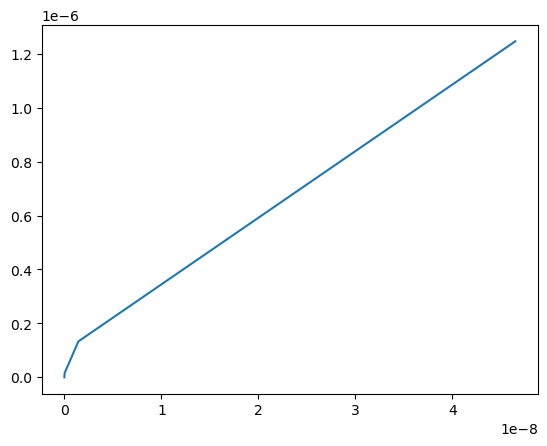

In [121]:
plt.plot(devs, delta)

In [122]:
str(JacobianMPD(0.0, y0, p)[1].flatten().tolist())

'[0.0, -0.09247484190907515, -8.956234773610682e-06, 0.0, -1.5097923535241915, -0.00010592763071853597, -0.0009274390528930724, -0.013923186317161473, -0.003328212892997335, -5.809163659605872e-05, -0.0003592247486049566, -0.0004068633645147933, 0.0, 0.00045920172152878026, -0.0003288463678296269, 0.0, -8.595546988858648e-05, 0.6941450432977029, -4.765709747561523e-06, -5.251395613411025e-06, -6.662004935471997e-05, -0.0027921966955849246, -1.8491104656332867e-06, -2.854707187091427e-06, 0.0, 0.01173470884523545, 3.072033253978714e-06, 0.0, 0.00042041633193656234, 2.661363153299738e-06, 0.028234477778267267, 2.5397398407619965e-05, 0.00016664051187100597, 1.925204141468834e-06, 0.00012064529470930295, 0.00016715129415848223, 0.0, -0.02910772910360408, -5.458686041310026e-07, 0.0, -0.01392316565002028, -6.457579047177574e-06, -5.601163622325941e-05, 0.026775533501360842, -0.0011503150466823885, -9.563348314850805e-06, -7.384123963769764e-05, -8.190888824930499e-05, 0.0, -1.5154747858675

In [123]:
print(jacob[1])

[[ 0.00000000e+00 -9.24748419e-02 -8.95623477e-06  0.00000000e+00
  -1.50979235e+00 -1.05927631e-04 -9.27439053e-04 -1.39231863e-02
  -3.32821289e-03 -5.80916366e-05 -3.59224749e-04 -4.06863365e-04]
 [ 0.00000000e+00  4.59201722e-04 -3.28846368e-04  0.00000000e+00
  -8.59554699e-05  6.94145043e-01 -4.76570975e-06 -5.25139561e-06
  -6.66200494e-05 -2.79219670e-03 -1.84911047e-06 -2.85470719e-06]
 [ 0.00000000e+00  1.17347088e-02  3.07203325e-06  0.00000000e+00
   4.20416332e-04  2.66136315e-06  2.82344778e-02  2.53973984e-05
   1.66640512e-04  1.92520414e-06  1.20645295e-04  1.67151294e-04]
 [ 0.00000000e+00 -2.91077291e-02 -5.45868604e-07  0.00000000e+00
  -1.39231657e-02 -6.45757905e-06 -5.60116362e-05  2.67755335e-02
  -1.15031505e-03 -9.56334831e-06 -7.38412396e-05 -8.19088882e-05]
 [ 0.00000000e+00 -1.51547479e-05 -9.60812613e-04  0.00000000e+00
  -3.32293477e-06  1.66915981e-03 -1.57244697e-05 -4.69213661e-08
  -6.18857894e-06 -3.12439177e-04 -4.43503627e-06 -3.32619722e-06]
 [ 0.

In [124]:
def solve_combined(t, y, p):
    mpdarr, jac = JacobianMPD(t,y[:12],p)

    dY = y[12:]

    # dY_dt = np.einsum("ij,j->i", jac, dY)
    dY_dt= jac.dot(dY)

    dydtf = dY_dt.flatten()

    du_ = np.zeros((24,))

    du_[:12] = mpdarr
    du_[12:] = dydtf

    return du_

## Create a Deviation Vector satisfying Constrains

In [125]:
dp0, dp3, ds0 = smp.symbols("dp0 dp3 ds0")
# ds0=0.0

In [126]:
EPS=1e-6

In [127]:
rany0 = (
    np.random.uniform(
        0.0,
        1.0,
        (12,),
    ).astype(object)
    * EPS
)
rany0[[0, 4, 7, 8]] = [0.0, dp0, dp3, ds0]

In [128]:
ry0 = y0 + rany0

In [129]:
rgkinv= cot_metric_tensor(ry0[1],ry0[2],a0,M)

In [130]:
eqC1 = get_norm(ry0[4:8], rgkinv) + m**2

In [131]:
eqC2 = get_norm(ry0[8:], rgkinv) - S**2

In [132]:
eqC3 = np.einsum("ij,j,i->", rgkinv, ry0[4:8], ry0[8:])

In [133]:
Croots = smp.solve([eqC1, eqC2, eqC3], [dp0, dp3, ds0])
# Croots = smp.solve([eqC1, eqC3], [dp0, dp3])
display(Croots)

[(1.87385836906692e-7, -2.75401868520036e-6, -3.83690172133147e-7),
 (0.0463209810356328, -5.18813741801463, -0.681298269014363),
 (1.80801120417190, -2.75401869217682e-6, -0.681298269014363),
 (1.85433563659943, -5.18813741801463, -3.83690172133147e-7)]

In [134]:
ndp0, ndp3, nds0 = Croots[0]

In [135]:
rany0[[4, 7, 8]] = [ndp0, ndp3, nds0]

In [136]:
ry0 = (y0 + rany0).astype(float)

In [137]:
dy0=ry0-y0

In [138]:
np.linalg.norm(dy0)

3.2341445633253768e-06

In [139]:
w0 = (
    dy0
)

In [140]:
w0

array([ 0.00000000e+00,  7.93662084e-07,  4.55550290e-07,  3.47281443e-07,
        1.87385837e-07,  2.35031635e-07,  8.55917965e-07, -2.75401869e-06,
       -3.83690172e-07,  2.74057340e-07,  9.07211642e-07,  2.20759477e-07])

In [141]:
cics= np.array([y0,w0]).flatten()

In [142]:
cics.shape

(24,)

In [143]:
solve_combined(0.0, cics, p)

array([ 1.33675022e+00,  6.86898389e-03, -3.35338987e-02,  8.07377804e-02,
        1.90690026e-05, -1.68170501e-03,  7.64234369e-05,  1.66432523e-05,
        7.73583897e-05, -7.66743332e-02,  3.03645849e-05, -7.62708820e-03,
       -3.17940182e-07,  1.62612997e-07,  3.35735907e-08, -9.91470604e-08,
       -1.59382718e-10, -7.04092542e-08, -7.81271129e-08,  1.32086352e-08,
        1.15072130e-08,  9.65092465e-08,  2.53194510e-07, -3.85467520e-07])

In [144]:
def jacobevolve_lyap(ics0, tau, tf, p):

    ti = 0.0  # * Initial Time
    timestep = np.arange(ti, tf, tau)  # * Time interval
    size = timestep.shape[0]

    X1t = np.zeros((size - 1))  # *Lyapunaov Exponents
    ics = ics0.copy()  # *We do not want to change our initial conditions
    mask = np.array(
        [True, True, True, True, False, True, True, False, False, True, True, True]
    )

    for i in range(0, size - 1):

        usol = solve_ivp(
            solve_combined,
            [0.0, tau],
            ics,
            t_eval=[tau],
            args=(p,),
            atol=1e-10,
            rtol=1e-10,
            max_step=tau,
        ).y[:, -1]

        xk = usol[:12]  # Orbit at t= tau
        wk = usol[12:]  # Deviations at t=tau

        # *---------------------The following algorithm is from the paper
        
        

        alphak = np.linalg.norm(wk[mask])/np.linalg.norm(ics0[12:][mask])

        X1t[i]= np.log(alphak)


        # *----------------------Lyapunaov Exponents calculated above
        #! Now for another time step. Set the current solution as the initial conditions for next time steps
        ics[:12] = xk
        ics[12:] = wk

    return X1t

In [145]:
tf = 10000.0
tau = 100.0
timestep = np.arange(0.0, tf, tau)


In [146]:
# cslyap = evolve_lyap(cics, tau, tf, p)
cslyap = jacobevolve_lyap(cics, tau, tf, p)

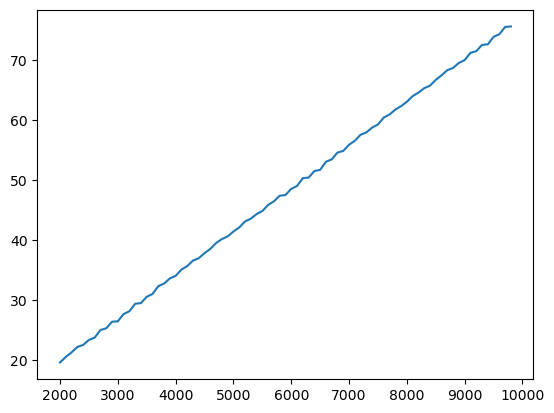

In [147]:
plt.plot(np.arange(0.0, tf, tau)[20:-1], cslyap[20:])

In [148]:
_, Lyap = (
    np.polynomial.polynomial.Polynomial.fit(
        np.arange(0.0, tf, tau)[20:-1], cslyap[20:], 1
    )
    .convert()
    .coef
)

In [149]:
Lyap

0.00722136004387327

In [150]:
0.003391384212679309 #Chaotic IC BY LE and PC
0.00010867631887969834  # Non Chaotic IC BY LE and PC
0.0072213600428502256  # Chaotic IC BY LE and PC
0.0001839836248977454  # Non Chaotic IC BY LE and PC 
0.00018396125058859535  # Non Chaotic IC BY LE and PC
0.014988482968529874 #Chaotic IC By LE and PC
0.00019380439883617 #? Quasi Periodic , LE and PC do not agree

0.00019380439883617

### Gravitational Waves

In [97]:
# @nb.njit
def hplus(t,y0 ,p ):
    """

    Args:
        t ([float]): Time, not needed in this function
        dH ([ndarray]): Solution of differential Equation at various time steps, shape (n,6)
        R ([float]): Distance of observer and the system
        mu ([float]): Mass of the particle
        Theta ([float]): Location of the observer
        Psi ([float]): Location of the observer
        alpha ([float]): Parameter of the theory

    Returns:
        Expression of hplus ([ndarray]) at various time: Shape (n,6)
    """
    # Compute the hplus expression using NumPy

    r,theta,a,M= y0[1],y0[2],p[0],p[2]

    pvector= y0[4:8]
    svector= y0[8:]

    gk = cov_metric_tensor(r, theta, a, M)  #! g_{ij}
    gkinv = cot_metric_tensor(r, theta, a, M)
    cs = kerr_christoffel(r, theta, a, M)  #! G^i_{jk}
    Riemann = kerr_riemann_tensor(r, theta, a, M)  #! R^a_{bcd}
    levi = levi_civita_tensor(gk)  #! e^{abcd}

    levi_mixed = (
        gk.dot(
            gk.dot(levi.reshape((4, -1)))
            .reshape((4, 4, 4, 4))
            .transpose(1, 0, 2, 3)
            .reshape((4, -1))
        )
        .reshape((4, 4, 4, 4))
        .transpose(1, 0, 2, 3)
    )

    dRuluu = 0.5 * np.matmul(Riemann.reshape((-1, 16)), levi.reshape((16, -1))).reshape(
        (4, 4, 4, 4)
    )

    ddRuuuu = 0.5 * np.einsum(
        "bi,aips,psuv->abuv", gkinv, dRuluu, levi_mixed
    )  #! *R*^{abuv}

    dgk = Dcov_metric_tensor(r, theta, a, M)  #! Dgk_{auv}
    dgkinv = Dcot_metric_tensor(r, theta, a, M)  #! Dgk^{uv}_a
    # dcs = Dkerr_christoffel(r, theta, a, M)  #! Dcs^a_(bcd)
    dRiemann = DRijkl(r, theta, a, M)  #! DR^a_{bcde}
    dg = np.einsum("gd,gda->a", gkinv, dgk)  #! D(Det(g))
    dg = (cs[0, 0, :] + cs[1, 1, :] + cs[2, 2, :] + cs[3, 3, :]) * 2
    dlevi = -np.einsum("uvps,a->uvpsa", levi, dg) * 0.5  #! Deps^{uvpsa}

    DdRuluu = 0.5 * (
        np.einsum("abpsk,psuv->abuvk", dRiemann, levi)
        + np.einsum("abps,psuvk->abuvk", Riemann, dlevi)
    )  #! DR*^a_{buv}

    # DdRlluu = np.einsum("ai,ibupk->abupk", gk, DdRuluu) + np.einsum(
    #     "aik,ibup->abupk", dgk, dRuluu
    # )  #! Changed this

    # DdRlluu = gk.dot(DdRuluu.reshape((4, -1))).reshape((4, 4, 4, 4, 4)) + np.einsum(
    #     "aik,ibup->abupk", dgk, dRuluu
    # )  #! Changed this

    DddRuuuu = 0.5 * (
        np.einsum("bi,aipsk,psuv->abuvk", gkinv, DdRuluu, levi_mixed, optimize=True)
        + np.einsum("bik,aips,psuv->abuvk", dgkinv, dRuluu, levi_mixed, optimize=True)
        + np.einsum(
            "bi,aips,pm,sn,mnuvz->abuvz", gkinv, dRuluu, gk, gk, dlevi, optimize=True
        )
        + np.einsum(
            "bi,aips,pmz,sn,mnuv->abuvz", gkinv, dRuluu, dgk, gk, levi, optimize=True
        )
        + np.einsum(
            "bi,aips,pm,snz,mnuv->abuvz", gkinv, dRuluu, gk, dgk, levi, optimize=True
        )
    )  #! D*R*^{abuv}

    wu = -ddRuuuu.dot(svector).dot(pvector).dot(svector)

    N = np.sqrt(1.0 / (1.0 - gk.dot(wu).dot(wu) - 2.0 * pvector.dot(wu)))

    dxdtau = calculate_four_velocity(
        gk=gk, gkinv=gkinv, pvector=pvector, svector=svector, ddRuuuu=ddRuuuu
    )  #!dx_mu

    dpdtau = calculate_four_momentum(
        pvector=pvector, uvector=dxdtau, svector=svector, cs=cs, dRlluu=dRlluu
    )
    #!dp_{mu}

    dsdtau = calculate_four_spin(
        pvector=pvector, uvector=dxdtau, svector=svector, cs=cs, dRuluu=dRuluu
    )  #! ds_mu

    dwudtau= (-np.einsum("uabgd,d,a,b,g->u",DddRuuuu,dxdtau,svector,pvector,svector)
              -np.einsum("uabg,a,b,g->u",ddRuuuu,dsdtau,pvector,svector)
              -np.einsum("uabg,a,b,g->u",ddRuuuu,svector,dpdtau,svector)
              -np.einsum("uabg,a,b,g->u",ddRuuuu,svector,pvector,dsdtau))

    dpudtau= np.einsum("uvd,d,v->u",dgkinv,dxdtau,pvector) + np.einsum("uv,v->u",gkinv,dpdtau)

    DN= N**3 *(np.einsum("u,u->",dwudtau,pvector)+np.einsum("u,u->",dwudtau,wu) + 0.5*np.einsum("uvd,d,u,v->",dgk,dxdtau,wu,wu))

    dvudtau= DN*(np.einsum("ij,j->i",gkinv,pvector) + wu) + \
             N*(np.einsum("uvd,d,v->u",dgkinv,dxdtau,pvector)+ np.einsum("uv,v->u",gkinv,dpdtau)+ dwudtau)
    

    d2xudtau= dvudtau/(dxdtau**2)+ dxdtau*(-dvudtau[0]/dxdtau[0]**3) 

    expression = (
        m
        / (2.0 * R)
        * (
            drdt**2
            * (
                (cos(2 * Theta) + 3) * sin(theta(t)) ** 2 * cos(2 * Phi - 2 * phi(t))
                + (3 * cos(2 * theta(t)) + 1) * sin(Theta) ** 2
                - 2 * sin(2 * Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
            )
            + 2
            * drdt
            * (
                2
                * dphidt
                * (
                    (cos(2 * Theta) + 3)
                    * sin(2 * Phi - 2 * phi(t))
                    * sin(theta(t)) ** 2
                    - sin(2 * Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                )
                + dthetadt
                * (
                    (
                        (cos(2 * Phi - 2 * phi(t)) + 3) * cos(2 * Theta)
                        - 6 * sin(Phi - phi(t)) ** 2
                    )
                    * sin(2 * theta(t))
                    - 4 * sin(2 * Theta) * cos(Phi - phi(t)) * cos(2 * theta(t))
                )
            )
            * r(t)
            + (
                d2rdt
                * (
                    (cos(2 * Theta) + 3)
                    * sin(theta(t)) ** 2
                    * cos(2 * Phi - 2 * phi(t))
                    + (3 * cos(2 * theta(t)) + 1) * sin(Theta) ** 2
                    - 2 * sin(2 * Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
                )
                + (
                    d2phidt
                    * (
                        (cos(2 * Theta) + 3)
                        * sin(2 * Phi - 2 * phi(t))
                        * sin(theta(t)) ** 2
                        - sin(2 * Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                    )
                    + d2thetadt
                    * (
                        (cos(2 * Phi - 2 * phi(t)) + 3)
                        * sin(theta(t))
                        * cos(2 * Theta)
                        * cos(theta(t))
                        - 2 * sin(2 * Theta) * cos(Phi - phi(t)) * cos(2 * theta(t))
                        - 3 * sin(Phi - phi(t)) ** 2 * sin(2 * theta(t))
                    )
                    + dphidt**2
                    * (
                        -2
                        * (cos(2 * Theta) + 3)
                        * sin(theta(t)) ** 2
                        * cos(2 * Phi - 2 * phi(t))
                        + sin(2 * Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
                    )
                    + 2
                    * dphidt
                    * dthetadt
                    * (
                        (cos(2 * Theta) + 3)
                        * sin(2 * Phi - 2 * phi(t))
                        * sin(2 * theta(t))
                        - 2 * sin(2 * Theta) * sin(Phi - phi(t)) * cos(2 * theta(t))
                    )
                    + dthetadt**2
                    * (
                        (
                            (cos(2 * Phi - 2 * phi(t)) + 3) * cos(2 * Theta)
                            - 6 * sin(Phi - phi(t)) ** 2
                        )
                        * cos(2 * theta(t))
                        + 4 * sin(2 * Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
                    )
                )
                * r(t)
            )
            * r(t)
        )
    )

    return expression

In [98]:
# @snoop
# @nb.njit
# Define the Python function 'hcross'
def hcross(t, dH, R, mu, Theta, Psi, alpha):
    """

    Args:
        t ([float]): Time, not needed in this function
        dH ([ndarray]): Solution of differential Equation at various time steps, shape (n,6)
        R ([float]): Distance of observer and the system
        mu ([float]): Mass of the particle
        Theta ([float]): Location of the observer
        Psi ([float]): Location of the observer
        alpha ([float]): Parameter of the theory

    Returns:
        Expression of hcross ([ndarray]) at various time: Shape (n,6)
    """
    # Compute the hcross expression using NumPy



    # Compute the expression using NumPy
    expression = (
        m
        / R
        * (
            2
            * drdt**2
            * (
                sin(Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                - sin(2 * Phi - 2 * phi(t)) * sin(theta(t)) ** 2 * cos(Theta)
            )
            + 4
            * drdt
            * (
                dphidt
                * (
                    -sin(Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
                    + 2 * sin(theta(t)) ** 2 * cos(Theta) * cos(2 * Phi - 2 * phi(t))
                )
                + dthetadt
                * (
                    2 * sin(Theta) * sin(Phi - phi(t)) * cos(2 * theta(t))
                    - sin(2 * Phi - 2 * phi(t)) * sin(2 * theta(t)) * cos(Theta)
                )
            )
            * r(t)
            - (
                2
                * d2rdt
                * (
                    -sin(Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                    + sin(2 * Phi - 2 * phi(t)) * sin(theta(t)) ** 2 * cos(Theta)
                )
                + (
                    d2phidt
                    * (
                        sin(Theta) * sin(2 * theta(t)) * cos(Phi - phi(t))
                        - 2
                        * sin(theta(t)) ** 2
                        * cos(Theta)
                        * cos(2 * Phi - 2 * phi(t))
                    )
                    + d2thetadt
                    * (
                        -2 * sin(Theta) * sin(Phi - phi(t)) * cos(2 * theta(t))
                        + sin(2 * Phi - 2 * phi(t)) * sin(2 * theta(t)) * cos(Theta)
                    )
                    + dphidt**2
                    * (
                        sin(Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                        - 4
                        * sin(2 * Phi - 2 * phi(t))
                        * sin(theta(t)) ** 2
                        * cos(Theta)
                    )
                    + 4
                    * dphidt
                    * dthetadt
                    * (
                        sin(Theta) * cos(Phi - phi(t)) * cos(2 * theta(t))
                        - sin(2 * theta(t)) * cos(Theta) * cos(2 * Phi - 2 * phi(t))
                    )
                    + 2
                    * dthetadt**2
                    * (
                        2 * sin(Theta) * sin(Phi - phi(t)) * sin(2 * theta(t))
                        + sin(2 * Phi - 2 * phi(t)) * cos(Theta) * cos(2 * theta(t))
                    )
                )
                * r(t)
            )
            * r(t)
        )
    )

    return expression